# Graph embeddings

This notebook can be used to obtain different embeddings for a provided input graph using different node embedding models such as ARGAE, GAE and Node2Vec.

---

## 0. Environmental setup

In [10]:
import pandas as pd
import networkx as nx
import numpy as np
import seaborn as sns
import sys
import os
import random
import matplotlib.pyplot as plt
import community as community_louvain
from torch_geometric.data import Data
from torch_geometric.nn import Node2Vec
from torch import LongTensor, FloatTensor
from torch_geometric.utils import train_test_split_edges, from_networkx
import torch_geometric.transforms as T
import torch
from tqdm import tqdm
from torch_geometric.datasets import PPI, LastFMAsia, Planetoid, KarateClub
from torch_geometric.nn import GAE, GCNConv, Sequential
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, RobustScaler
import umap
import umap.plot
import scanpy as sc
from collections import Counter

sys.path.append("../../../")

from src.models.ae import GraphConvAE
from src.utils.basic.visualization import plot_train_val_hist

seed = 1234
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [11]:
def process_single_epoch(
    model, data, node_feature_key, mode, optimizer, edge_weight_key=None
):
    inputs = getattr(data, node_feature_key).float()
    if edge_weight_key is not None:
        edge_weight = getattr(data, edge_weight_key).float()
    else:
        edge_weight = None

    if mode == "train":
        model.train()
        optimizer.zero_grad()
        latents = model.encode(
            inputs,
            data.edge_index,
            edge_weight=edge_weight,
        )
        # Negative edges created via negative sampling
        loss = model.recon_loss(latents, data.pos_edge_label_index)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    else:
        model.eval()
        latents = model.encode(
            inputs,
            data.edge_index,
            edge_weight=edge_weight,
        )
        loss = model.recon_loss(latents, data.pos_edge_label_index)

    return loss.item()


def test_gae(model, data, node_feature_key, edge_weight_key=None):
    model.eval()

    inputs = getattr(data, node_feature_key).float()
    if edge_weight_key is not None:
        edge_weight = getattr(data, edge_weight_key).float()
    else:
        edge_weight = None

    data = data.to(device)
    latents = model.encode(
        inputs,
        data.edge_index,
        edge_weight=edge_weight,
    )
    auc, ap = model.test(
        latents,
        data.pos_edge_label_index,
        data.neg_edge_label_index,
    )
    return auc, ap


def train_gae(
    model,
    data_dict,
    node_feature_key,
    optimizer,
    n_epochs=500,
    early_stopping=20,
    edge_weight_key=None,
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.device = device
    print("Using {}".format(device))
    best_val_loss = np.infty
    loss_hist = {"train": [], "val": []}
    es_counter = 0

    best_model_weights = None
    best_epoch = -1

    for i in range(n_epochs):
        print("---" * 20)
        print("EPOCH {}/{}".format(i + 1, n_epochs))
        if es_counter < early_stopping:
            for mode in ["train", "val"]:
                data = data_dict[mode].to(device)
                loss = process_single_epoch(
                    model=model,
                    data=data,
                    node_feature_key=node_feature_key,
                    edge_weight_key=edge_weight_key,
                    mode=mode,
                    optimizer=optimizer,
                )
                print("{} loss:".format(mode.upper()), loss)
                loss_hist[mode].append(loss)

                if mode == "val":
                    if loss < best_val_loss:
                        es_counter = 0
                        best_val_loss = loss
                        best_model_weights = model.state_dict()
                        best_epoch = i
                    else:
                        es_counter += 1
                    auc, ap = test_gae(
                        model=model, data=data, node_feature_key=node_feature_key
                    )
                    print("VAL AUC: {} \t AP: {}".format(auc, ap))
        else:
            print("Training stopped after {} epochs".format(i + 1))
            print("Best model found at epoch {}".format(best_epoch))
            break

    print("---" * 20)
    model.load_state_dict(best_model_weights)
    data = data_dict["test"].to(device)
    auc, ap = test_gae(
        model=model,
        data=data,
        node_feature_key=node_feature_key,
        edge_weight_key=edge_weight_key,
    )
    print("TEST AUC: {} \t AP: {}".format(auc, ap))
    return model, loss_hist

<IPython.core.display.Javascript object>

---

## 1. Read in data

First, we will read in data i.e. a graph structure that defines our inferred interactome of U2OS cells.

In [12]:
spearman_interactome = nx.read_gpickle(
    "../../../data/ppi/inference_results/conf_hub_spearman_sol_ext.pkl"
)
print(nx.info(spearman_interactome))

Name: conf_hub_spearman_sol_ext
Type: Graph
Number of nodes: 754
Number of edges: 1826
Average degree:   4.8435


<IPython.core.display.Javascript object>

The interactome consists of 754 nodes and 1'832 edges.

Let us also load the scRNAseq data that we could provide as additional input to the GCAE to refine the embedding.

In [13]:
gex_adata = sc.read("../../../data/gex/scrnaseq/fucci_adata.h5")
gex_adata.var_names_make_unique()

<IPython.core.display.Javascript object>

We will also load a number of genes that can be used to identify the cell cycle stage for each cell in the scRNAseq data to be able to later construct cell-cycle-stage specific pseudo-bulk RNAseq data from the scRNAseq. Such pseudo-samples might be favored over directly inputting the scRNAseq data as they are of lower-dimensionality and likely less sparse.

In [14]:
url = "https://raw.githubusercontent.com/theislab/scanpy_usage/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt"
cell_cycle_genes_scanpy = pd.read_csv(url, header=None)
s_genes = np.array(cell_cycle_genes_scanpy.iloc[:43, 0])
g2m_genes = np.array(cell_cycle_genes_scanpy.iloc[43:, 0])

<IPython.core.display.Javascript object>

The crresponding gene sets allow us to score each sample with respect to identify the individual cell stages.

In [15]:
sc.tl.score_genes_cell_cycle(gex_adata, s_genes=s_genes, g2m_genes=g2m_genes)

<IPython.core.display.Javascript object>

We will store these labels. There are 607 cells in G2/M, 423 in S and 96 in G1 phase.

In [16]:
Counter(gex_adata.obs.phase)

Counter({'G2M': 607, 'S': 423, 'G1': 96})

<IPython.core.display.Javascript object>

In [17]:
cc_labels = pd.DataFrame(
    np.array(gex_adata.obs.phase), index=gex_adata.obs_names, columns=["phase"]
)
cc_labels.head()

phase
A10_355   G2M
A10_356   G2M
A10_357   G2M
A11_355     S
A11_356   G2M

<IPython.core.display.Javascript object>

Next, we will also transform the gex_data into a dataframe and split it accordingly to the different cell cycle stages in pseudo-samples.

In [18]:
gex_data = pd.DataFrame(
    gex_adata.X, columns=gex_adata.var_names, index=gex_adata.obs_names
)
gex_data.columns = [c.upper() for c in gex_data.columns]
gex_data = gex_data.loc[
    :, set(spearman_interactome.nodes()).intersection(gex_data.columns)
]

<IPython.core.display.Javascript object>

In [19]:
g2m_gex_data = gex_data.loc[cc_labels.phase == "G2M"]
g1_gex_data = gex_data.loc[cc_labels.phase == "G1"]
s_gex_data = gex_data.loc[cc_labels.phase == "S"]

<IPython.core.display.Javascript object>

Next, we will create pseudo-bulk data by computing the mean of the log1p-transformed read counts for the respective cells of the three cell cycle stages and combine the data to a three sample dataset.

In [20]:
g2m_gex_bulk = g2m_gex_data.mean()
g1_gex_bulk = g1_gex_data.mean()
s_gex_bulk = s_gex_data.mean()

pbulk_gex_data = pd.DataFrame(
    np.array([np.array(g2m_gex_bulk), np.array(g1_gex_bulk), np.array(s_gex_bulk)]),
    index=["g2m", "g1", "s"],
    columns=g2m_gex_data.columns,
)

<IPython.core.display.Javascript object>

Finally, we will z-transform both the pseudo-bulk and the scRNAseq data.

In [21]:
gex_data_z = pd.DataFrame(
    StandardScaler().fit_transform(gex_data),
    index=gex_data.index,
    columns=gex_data.columns,
)
gex_data_z.describe()

DNMT3B        UBQLN4      TRAF3IP2         CPT1A         ZWINT  \
count  1.126000e+03  1.126000e+03  1.126000e+03  1.126000e+03  1.126000e+03   
mean  -6.775661e-09  1.016349e-08  2.032698e-08 -1.693915e-09 -1.693915e-09   
std    1.000444e+00  1.000444e+00  1.000444e+00  1.000444e+00  1.000444e+00   
min   -1.958330e+00 -3.142328e+00 -1.577571e+00 -2.728680e-01 -4.775139e+00   
25%   -4.467663e-01 -3.379459e-01 -7.482492e-01 -2.728680e-01 -5.684005e-02   
50%    2.879506e-01  2.110950e-01  2.713434e-01 -2.728680e-01  2.689907e-01   
75%    7.340782e-01  6.499939e-01  7.791048e-01 -2.728680e-01  4.909315e-01   
max    1.746837e+00  2.134235e+00  1.827901e+00  6.077503e+00  1.269211e+00   

               ELK1          EDN1         CENPA          MDM4           FOS  \
count  1.126000e+03  1.126000e+03  1.126000e+03  1.126000e+03  1.126000e+03   
mean   3.387831e-09 -6.775661e-09  6.775661e-09  1.693915e-08  1.016349e-08   
std    1.000444e+00  1.000444e+00  1.000444e+00  1.000444e+00  1.000444e+00   
min   -6.989488e+00 -2.350320e+00 -1.887030e+00 -6.278107e+00 -5.119626e-01   
25%   -5.209266e-01 -4.168399e-01 -4.892737e-01 -5.063339e-01 -5.119626e-01   
50%    1.306089e-01  2.301319e-01  2.508944e-01  1.546403e-01 -5.119626e-01   
75%    6.645022e-01  7.263648e-01  7.608008e-01  6.785816e-01 -5.119626e-01   
max    2.274377e+00  2.065315e+00  1.616197e+00  2.196656e+00  4.413837e+00   

       ...         CSMD1          MCM3         FRMD6          ATF6  \
count  ...  1.126000e+03  1.126000e+03  1.126000e+03  1.126000e+03   
mean   ...  1.524524e-08  8.469577e-10  3.387831e-09  6.775661e-09   
std    ...  1.000444e+00  1.000444e+00  1.000444e+00  1.000444e+00   
min    ... -1.457326e+00 -5.465086e+00 -5.231229e+00 -6.616817e+00   
25%    ... -1.457326e+00 -5.335235e-01 -3.478907e-01 -3.981375e-01   
50%    ...  2.156027e-01  1.298629e-01  1.453418e-01  1.470501e-01   
75%    ...  8.448712e-01  7.302515e-01  5.771048e-01  6.437151e-01   
max    ...  1.739827e+00  1.733249e+00  2.490532e+00  2.738520e+00   

               RAC1        COL3A1           NDN      ARHGAP33       RASSF1  \
count  1.126000e+03  1.126000e+03  1.126000e+03  1.126000e+03  1126.000000   
mean   6.775661e-09  3.387831e-09  1.016349e-08  2.117394e-09     0.000000   
std    1.000444e+00  1.000444e+00  1.000444e+00  1.000444e+00     1.000444   
min   -5.377803e+00 -2.456297e-01 -5.210977e+00 -9.737657e-01    -2.122725   
25%   -5.340350e-01 -2.456297e-01 -5.747207e-01 -9.737657e-01    -0.335279   
50%    6.811953e-02 -2.456297e-01  8.609742e-02  1.183863e-01     0.294781   
75%    6.397686e-01 -2.456297e-01  6.605559e-01  8.536218e-01     0.685816   
max    2.616945e+00  8.149598e+00  2.728680e+00  2.760411e+00     1.863214   

             S100A6  
count  1.126000e+03  
mean  -1.693915e-09  
std    1.000444e+00  
min   -5.233489e+00  
25%   -6.725710e-01  
50%   -6.736462e-02  
75%    6.304283e-01  
max    3.484367e+00  

[8 rows x 754 columns]

<IPython.core.display.Javascript object>

In [22]:
pbulk_gex_data_z = pd.DataFrame(
    StandardScaler().fit_transform(pbulk_gex_data),
    index=pbulk_gex_data.index,
    columns=pbulk_gex_data.columns,
)
pbulk_gex_data_z.describe()

DNMT3B        UBQLN4      TRAF3IP2     CPT1A     ZWINT      ELK1  \
count  3.000000e+00  3.000000e+00  3.000000e+00  3.000000  3.000000  3.000000   
mean   4.967054e-09  1.986822e-08  9.934108e-09  0.000000  0.000000  0.000000   
std    1.224745e+00  1.224745e+00  1.224745e+00  1.224745  1.224745  1.224745   
min   -1.315345e+00 -1.412713e+00 -1.028325e+00 -0.854682 -1.414201 -1.196843   
25%   -5.537811e-01 -3.813772e-01 -6.774712e-01 -0.701559 -0.356096 -0.625430   
50%    2.077828e-01  6.499590e-01 -3.266177e-01 -0.548435  0.702009 -0.054017   
75%    6.576725e-01  7.063567e-01  5.141624e-01  0.427341  0.707101  0.598421   
max    1.107562e+00  7.627543e-01  1.354942e+00  1.403117  0.712192  1.250860   

           EDN1         CENPA      MDM4       FOS  ...         CSMD1  \
count  3.000000  3.000000e+00  3.000000  3.000000  ...  3.000000e+00   
mean   0.000000 -3.973643e-08  0.000000  0.000000  ... -3.973643e-08   
std    1.224745  1.224745e+00  1.224745  1.224745  ...  1.224745e+00   
min   -1.410002 -1.284274e+00 -1.413619 -1.313034  ... -1.413544e+00   
25%   -0.399725 -5.774762e-01 -0.371166 -0.555721  ... -3.722236e-01   
50%    0.610552  1.293221e-01  0.671287  0.201592  ...  6.690971e-01   
75%    0.705001  6.421372e-01  0.706809  0.656517  ...  7.067721e-01   
max    0.799450  1.154952e+00  0.742332  1.111442  ...  7.444471e-01   

               MCM3         FRMD6          ATF6          RAC1        COL3A1  \
count  3.000000e+00  3.000000e+00  3.000000e+00  3.000000e+00  3.000000e+00   
mean   3.973643e-08 -1.986822e-08  3.973643e-08 -1.986822e-08  1.986822e-08   
std    1.224745e+00  1.224745e+00  1.224745e+00  1.224745e+00  1.224745e+00   
min   -1.225264e+00 -1.407422e+00 -1.131733e+00 -1.397737e+00 -7.275295e-01   
25%   -6.121125e-01 -4.117969e-01 -6.501476e-01 -4.426385e-01 -7.070075e-01   
50%    1.039095e-03  5.838284e-01 -1.685625e-01  5.124604e-01 -6.864855e-01   
75%    6.126321e-01  7.037111e-01  5.658664e-01  6.988686e-01  3.637648e-01   
max    1.224225e+00  8.235938e-01  1.300295e+00  8.852769e-01  1.414015e+00   

                NDN      ARHGAP33        RASSF1        S100A6  
count  3.000000e+00  3.000000e+00  3.000000e+00  3.000000e+00  
mean   1.986822e-08  1.986822e-08 -2.980232e-08  1.986822e-08  
std    1.224745e+00  1.224745e+00  1.224745e+00  1.224745e+00  
min   -1.058767e+00 -1.384707e+00 -1.360253e+00 -9.032685e-01  
25%   -6.706657e-01 -4.706160e-01 -5.076077e-01 -6.970070e-01  
50%   -2.825646e-01  4.434747e-01  3.450371e-01 -4.907455e-01  
75%    5.293834e-01  6.923533e-01  6.801262e-01  4.516343e-01  
max    1.341331e+00  9.412320e-01  1.015215e+00  1.394014e+00  

[8 rows x 754 columns]

<IPython.core.display.Javascript object>

---

For later visualization purposes, we will also read in a number of curated gene sets that are of particular interest for us as alterations in the corresponding genes are more likely to be reflected in structural changes in the cell than other pathways.

In [23]:
cc_genes = set(
    pd.read_csv("../../../data/other/reactome_cell_cycle.txt", index_col=0).index
)
co_genes = set(
    pd.read_csv("../../../data/other/reactome_chrom_org.txt", index_col=0).index
)
dr_genes = set(
    pd.read_csv("../../../data/other/reactome_dna_repair.txt", index_col=0).index
)
cd_genes = set(
    pd.read_csv("../../../data/other/reactome_cell_death.txt", index_col=0).index
)
cr_genes = set(
    pd.read_csv("../../../data/other/kegg_reg_act_cytoskeleton.txt", index_col=0).index
)
tfs = set(pd.read_csv("../../../data/other/human_tf_list.txt", index_col=0).index)

spec_results = pd.read_csv(
    "../../../data/other/specificity_screen_results.csv", index_col=0
)
spec_results = spec_results.loc[spec_results["selected"]]
spec_orf_targets = set(spec_results.index)

<IPython.core.display.Javascript object>

We will set the respective information and the expression across the individual cells as additional node attributes in the derived interactome.

In [24]:
for node in spearman_interactome.nodes(data=True):
    node[-1]["sc_gex"] = np.array(gex_data_z.loc[:, node[0]])
    node[-1]["pbulk_gex"] = np.array(pbulk_gex_data_z.loc[:, node[0]])
    node[-1]["name"] = node[0]
    node[-1]["cell_cycle"] = node[0] in cc_genes
    node[-1]["chromatin_org"] = node[0] in co_genes
    node[-1]["dna_repair"] = node[0] in dr_genes
    node[-1]["cytoskeleton_org"] = node[0] in cr_genes
    node[-1]["cell_death"] = node[0] in cd_genes
    node[-1]["tf"] = node[0] in tfs
    node[-1]["spec_target"] = node[0] in spec_orf_targets

for edge in spearman_interactome.edges(data=True):
    edge[-1]["spearmanr_weight"] = np.log(2 + (edge[-1]["spearmanr"]))

<IPython.core.display.Javascript object>

---

## 2. Data preprocessing

Next, we transform the graph into a data object that is complient with the pytorch_geometric specifications.

In [25]:
graph_data = from_networkx(spearman_interactome)
graph_data.id = torch.FloatTensor(np.identity(len(spearman_interactome)))

<IPython.core.display.Javascript object>

Next, we will split the data into training, validation and test set. We will use 70% of the edges for training, 10% for validation and the remaining 20% for testing.

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
transforms = T.Compose(
    [
        # T.ToUndirected(),
        T.ToDevice(device, attrs=["id", "sc_gex", "pbulk_gex"]),
        T.NormalizeFeatures(attrs=["sc_gex", "pbulk_gex"]),
        T.RandomLinkSplit(
            is_undirected=True,
            add_negative_train_samples=False,
            num_val=0.1,
            num_test=0.2,
            split_labels=True,
        ),
    ]
)
train_data, val_data, test_data = transforms(graph_data)

<IPython.core.display.Javascript object>

In [27]:
data_dict = {"train": train_data, "val": val_data, "test": test_data}

<IPython.core.display.Javascript object>

---

## 3. GAE embeddings

We set up our Graph-convolutional Autoencoder as defined by Kipf & Welling (2016) consisting of a two-layer GCNConv encoder model and a decoder that simply computes the inner products of the latent embeddings output by the decoder. Those values are tranformed using the sigmoid function to yield a probabilistic measure for the existence of an edge.

In [28]:
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels, hidden_dim):
        super().__init__()
        self.model = Sequential(
            "x, edge_index, edge_weight",
            [
                (GCNConv(in_channels, hidden_dim), "x, edge_index, edge_weight -> x"),
                torch.nn.PReLU(),
                # (GCNConv(hidden_dim, hidden_dim), "x, edge_index, edge_weight -> x"),
                # torch.nn.ReLU(inplace=True),
                (GCNConv(hidden_dim, out_channels), "x, edge_index, edge_weight -> x")
                # torch.nn.ReLU(inplace=True),
                # torch.nn.Linear(hidden_dim, out_channels),
            ],
        )

    def forward(self, x, edge_index, edge_weight=None):
        x = self.model(x, edge_index, edge_weight)
        return x

<IPython.core.display.Javascript object>

In [29]:
class EnsembleDecoder(torch.nn.Module):
    def __init__(self, adj_decoder, feature_decoder):
        self.adj_decoder = adj_decoder
        self.feature_decoder = feature_decoder

    def forward(self, x, edge_index):
        adj = self.adj_decoder(x, edge_index)
        feat = self.feature_decoder(x, edge_index)
        return adj, feat

<IPython.core.display.Javascript object>

In [30]:
class FCNFeatureDecoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels, hidden_dims, loss_fct):
        layers = []
        if hidden_dims is None or len(hidden_dims) == 0:
            layers.append(torch.nn.Linear(self.in_channels, out_channels))
        else:
            layers.append(
                torch.nn.Sequential(
                    torch.nn.Linear(in_channels, hidden_dims[0]),
                    torch.nn.PReLU(),
                    torch.nn.BatchNorm1D(hidden_dims[0]),
                )
            )
            for i in range(1, len(hidden_dims)):
                layers.append(
                    torch.nn.Sequential(
                        torch.nn.Linear(hidden_dims[i - 1], hidden_dims[i]),
                        torch.nn.PReLU(),
                        torch.nn.BatchNorm1D(hidden_dims[i]),
                    )
                )
            layers.append(torch.nn.Linear(hidden_dims[-1], out_channels))
        self.model = torch.nn.Sequential(*layers)
        self.loss_fct

    def forward(self, z, edge_index):
        x0, x1 = self.model(x[edge_index[0]]), self.model(x[edge_index[1]])

    def recon_loss(xpred, z, edge_index):
        x0, x1 = self.forward(z, edge_index)
        return self.loss_fct(x_pred[edge_index[0]], x0) + self.loss_fct(
            x_pred[edge_index[1]], x1
        )

<IPython.core.display.Javascript object>

Note, the exact definition of the model will depend on i.a. the type of node features we provide as input.

Thus, we will now define the functions required to train the model.

---

### 3.1. GCAE w/o node features

#### Model training

As a first setup we will use no specific node features to learn the graph embedding but simply provide the identity matrix node features. We aim to embed each node in a 64 dimensional space and follow the example by Kipf & Welling and set the hidden dimensionality to two times the embedding size.

In [31]:
node_feature_key = "id"
gae = GAE(GCNEncoder(in_channels=754, hidden_dim=128, out_channels=64))
gae

GAE(
  (encoder): GCNEncoder(
    (model): Sequential(
      (0): GCNConv(754, 128)
      (1): PReLU(num_parameters=1)
      (2): GCNConv(128, 64)
    )
  )
  (decoder): InnerProductDecoder()
)

<IPython.core.display.Javascript object>

The GAE consists of two-layer graph-convolutional encoder that maps the node embedding from 163-64-64 dimensions. That is the latent space will be given by a euclidean 64 dimensional space. We apply a ReLU activation for nonlinearity after the first GCNConv layer.
The decoder is simply an innerproduct decoder that takes the sigmoid of the inner product of the latent embeddings for two nodes in order to compute a probabilistic adjacency matrix.

The model is trained and shows a validation and testing AUC around 0.93 and similar AP for the link prediction based on the reconstructed adjacency matrix.

In [32]:
# inizialize the optimizer
optimizer = torch.optim.Adam(gae.parameters(), lr=0.01)

<IPython.core.display.Javascript object>

In [33]:
gae, loss_hist = train_gae(
    model=gae,
    data_dict=data_dict,
    node_feature_key=node_feature_key,
    optimizer=optimizer,
    n_epochs=300,
    early_stopping=50,
)

Using cuda
------------------------------------------------------------
EPOCH 1/300
TRAIN loss: 1.3839805126190186
VAL loss: 1.3760217428207397
VAL AUC: 0.7862576983456104 	 AP: 0.8264258854890569
------------------------------------------------------------
EPOCH 2/300
TRAIN loss: 1.3671045303344727
VAL loss: 1.338756799697876
VAL AUC: 0.786197319164352 	 AP: 0.8035162551249121
------------------------------------------------------------
EPOCH 3/300
TRAIN loss: 1.3084237575531006
VAL loss: 1.329211950302124
VAL AUC: 0.7619248882985146 	 AP: 0.7856931642348084
------------------------------------------------------------
EPOCH 4/300
TRAIN loss: 1.280329942703247
VAL loss: 1.2851694822311401
VAL AUC: 0.7435998067866199 	 AP: 0.7797608025877627
------------------------------------------------------------
EPOCH 5/300
TRAIN loss: 1.1944684982299805
VAL loss: 1.2624213695526123
VAL AUC: 0.7348750150947954 	 AP: 0.776772424466547
------------------------------------------------------------
EPO

TRAIN loss: 0.7887043952941895
VAL loss: 1.1656453609466553
VAL AUC: 0.7549510928631807 	 AP: 0.8206410936018089
------------------------------------------------------------
EPOCH 53/300
TRAIN loss: 0.7960919737815857
VAL loss: 1.1825690269470215
VAL AUC: 0.7562190556696051 	 AP: 0.8212896251595425
------------------------------------------------------------
EPOCH 54/300
TRAIN loss: 0.793298602104187
VAL loss: 1.168319582939148
VAL AUC: 0.7545284385943727 	 AP: 0.820785579357262
------------------------------------------------------------
EPOCH 55/300
TRAIN loss: 0.8000575304031372
VAL loss: 1.1721444129943848
VAL AUC: 0.7519321338002656 	 AP: 0.8190213631200536
------------------------------------------------------------
EPOCH 56/300
TRAIN loss: 0.8032130599021912
VAL loss: 1.1550447940826416
VAL AUC: 0.7509660669001328 	 AP: 0.817718695456575
------------------------------------------------------------
EPOCH 57/300
TRAIN loss: 0.7927043437957764
VAL loss: 1.1626372337341309
VAL AUC: 

VAL AUC: 0.7698043714527232 	 AP: 0.8318069826036978
------------------------------------------------------------
EPOCH 105/300
TRAIN loss: 0.7837351560592651
VAL loss: 1.1752339601516724
VAL AUC: 0.7676609105180534 	 AP: 0.8302256135844938
------------------------------------------------------------
EPOCH 106/300
TRAIN loss: 0.7682834267616272
VAL loss: 1.139146327972412
VAL AUC: 0.7671476874773577 	 AP: 0.830001827009757
------------------------------------------------------------
EPOCH 107/300
TRAIN loss: 0.7777895331382751
VAL loss: 1.1113557815551758
VAL AUC: 0.76778166888057 	 AP: 0.8299290306526943
------------------------------------------------------------
EPOCH 108/300
TRAIN loss: 0.7830914258956909
VAL loss: 1.1481753587722778
VAL AUC: 0.7692911484120275 	 AP: 0.8304743193082916
------------------------------------------------------------
EPOCH 109/300
TRAIN loss: 0.7801650762557983
VAL loss: 1.1267063617706299
VAL AUC: 0.7712836613935515 	 AP: 0.8318199418298621
-----------

<IPython.core.display.Javascript object>

#### Visualization of the embeddings

After the training, we will use the trained model to compute the node embeddings.

In [34]:
graph_data = graph_data.to(gae.device)
inputs = getattr(graph_data, node_feature_key).float()
node_names = getattr(graph_data, "name")
cc_memberships = getattr(graph_data, "cell_cycle")
co_memberships = getattr(graph_data, "chromatin_org")
dr_memberships = getattr(graph_data, "dna_repair")
cd_memberships = getattr(graph_data, "cell_death")
cr_memberships = getattr(graph_data, "cytoskeleton_org")
tf_memberships = getattr(graph_data, "tf")
st_memberships = getattr(graph_data, "spec_target")

<IPython.core.display.Javascript object>

In [35]:
gae.eval()
latents = gae.encode(inputs, graph_data.edge_index)
latents = latents.detach().cpu().numpy()

<IPython.core.display.Javascript object>

In [36]:
norm_zs = StandardScaler().fit_transform(latents)
embs = TSNE(random_state=1234).fit_transform(norm_zs)
embs = pd.DataFrame(embs, columns=["tsne-0", "tsne-1"], index=node_names)
embs["cell_cycle"] = cc_memberships.cpu().numpy()
embs["chromatin_org"] = co_memberships.cpu().numpy()
embs["dna_repair"] = dr_memberships.cpu().numpy()
embs["cell_death"] = cd_memberships.cpu().numpy()
embs["cytoskeleton_org"] = cr_memberships.cpu().numpy()
embs["tfs"] = tf_memberships.cpu().numpy()
embs["spec_target"] = st_memberships.cpu().numpy()

<IPython.core.display.Javascript object>

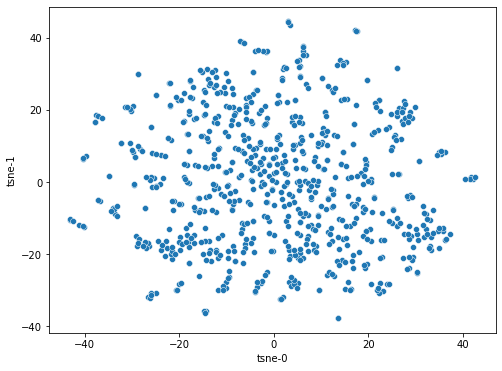

<IPython.core.display.Javascript object>

In [37]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(data=embs, x="tsne-0", y="tsne-1", cmap="viridis")

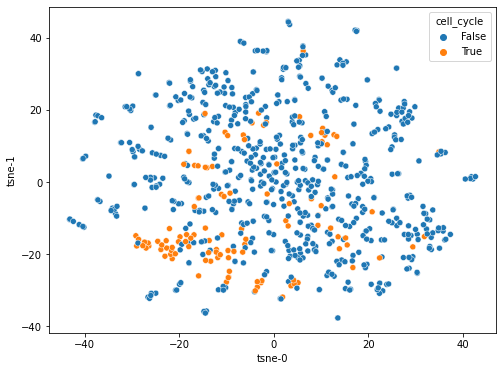

<IPython.core.display.Javascript object>

In [38]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cell_cycle"
)

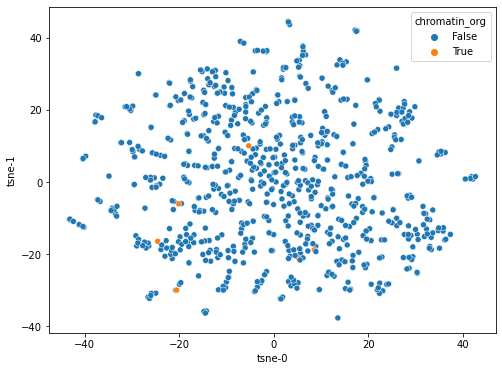

<IPython.core.display.Javascript object>

In [39]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="chromatin_org"
)

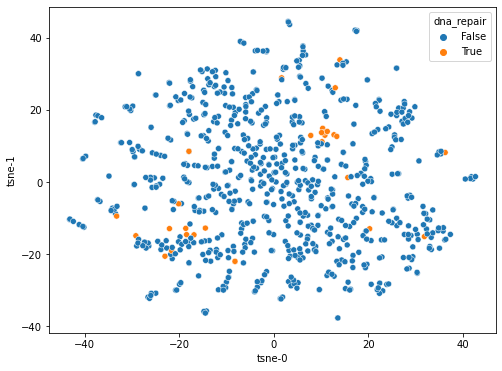

<IPython.core.display.Javascript object>

In [40]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="dna_repair"
)

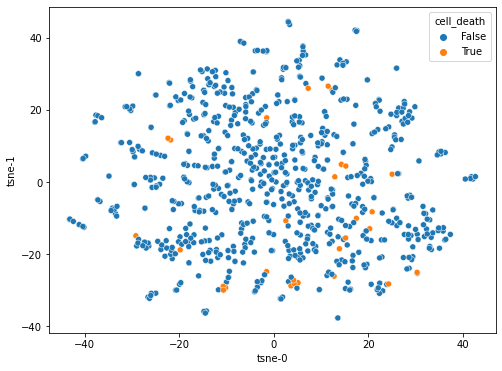

<IPython.core.display.Javascript object>

In [41]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cell_death"
)

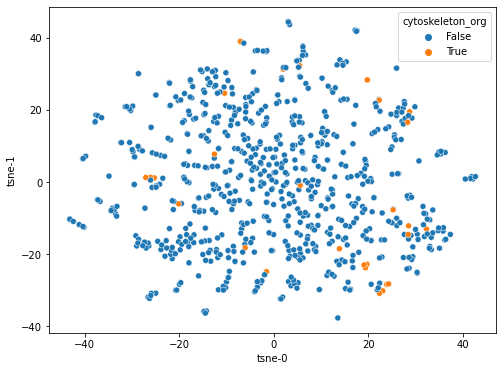

<IPython.core.display.Javascript object>

In [42]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cytoskeleton_org"
)

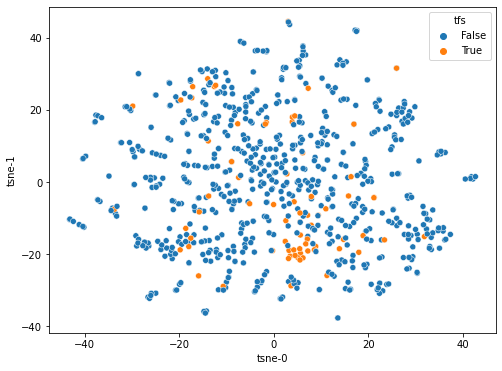

<IPython.core.display.Javascript object>

In [43]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="tfs")

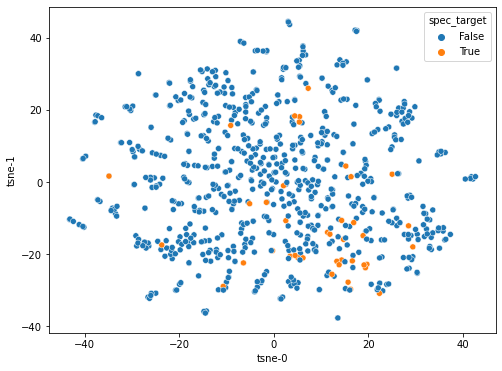

<IPython.core.display.Javascript object>

In [44]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="spec_target"
)

#### Save the embeddings

In [47]:
os.makedirs("../../../data/experiments/ppi_embeddings/gae_103121", exist_ok=True)
file_loc = "../../../data/experiments/ppi_embeddings/gae_103121/gae_conf_hub_ext_ppi_wo_gex.csv"
latents = pd.DataFrame(latents, index=node_names)
latents.to_csv(file_loc)

<IPython.core.display.Javascript object>

---


### 3.2. GCAE w. GEX node features

Next, we will train a similar 2-Layer GCAE providing the log-transformed and z-scored gene expression for the 1'126 cells as input.

In [48]:
node_feature_key = "sc_gex"
gex_gae = GAE(GCNEncoder(in_channels=1126, hidden_dim=128, out_channels=64))
gex_gae

GAE(
  (encoder): GCNEncoder(
    (model): Sequential(
      (0): GCNConv(1126, 128)
      (1): PReLU(num_parameters=1)
      (2): GCNConv(128, 64)
    )
  )
  (decoder): InnerProductDecoder()
)

<IPython.core.display.Javascript object>

In [49]:
# inizialize the optimizer
optimizer = torch.optim.Adam(gex_gae.parameters(), lr=0.0001)

<IPython.core.display.Javascript object>

#### Model training

In [50]:
gex_gae, loss_hist = train_gae(
    model=gex_gae,
    data_dict=data_dict,
    node_feature_key=node_feature_key,
    optimizer=optimizer,
    n_epochs=300,
    early_stopping=50,
)

Using cuda
------------------------------------------------------------
EPOCH 1/300
TRAIN loss: 5.681054592132568
VAL loss: 5.329008102416992
VAL AUC: 0.6894094916072938 	 AP: 0.641898576362397
------------------------------------------------------------
EPOCH 2/300
TRAIN loss: 5.086813449859619
VAL loss: 4.486212730407715
VAL AUC: 0.6909038763434368 	 AP: 0.6459255281938496
------------------------------------------------------------
EPOCH 3/300
TRAIN loss: 4.769842624664307
VAL loss: 4.4398698806762695
VAL AUC: 0.6901340417823933 	 AP: 0.6452205050383806
------------------------------------------------------------
EPOCH 4/300
TRAIN loss: 4.102092266082764
VAL loss: 3.993455171585083
VAL AUC: 0.6908434971621785 	 AP: 0.6459632254918328
------------------------------------------------------------
EPOCH 5/300
TRAIN loss: 4.166495323181152
VAL loss: 3.8753247261047363
VAL AUC: 0.6910548242965825 	 AP: 0.6506673912107097
------------------------------------------------------------
EPOCH 6

VAL loss: 1.6885159015655518
VAL AUC: 0.696202149498853 	 AP: 0.6807256401098658
------------------------------------------------------------
EPOCH 48/300
TRAIN loss: 1.2041213512420654
VAL loss: 1.6515693664550781
VAL AUC: 0.6966851829489192 	 AP: 0.6810448938372983
------------------------------------------------------------
EPOCH 49/300
TRAIN loss: 1.2740811109542847
VAL loss: 1.6383860111236572
VAL AUC: 0.6973493539427604 	 AP: 0.6815243229553909
------------------------------------------------------------
EPOCH 50/300
TRAIN loss: 1.2572964429855347
VAL loss: 1.6588529348373413
VAL AUC: 0.6981946624803768 	 AP: 0.6823400015420966
------------------------------------------------------------
EPOCH 51/300
TRAIN loss: 1.2456955909729004
VAL loss: 1.7164663076400757
VAL AUC: 0.699039971017993 	 AP: 0.6833906934607779
------------------------------------------------------------
EPOCH 52/300
TRAIN loss: 1.1918411254882812
VAL loss: 1.6901001930236816
VAL AUC: 0.6995833836493178 	 AP: 0.68

TRAIN loss: 1.0887470245361328
VAL loss: 1.635913610458374
VAL AUC: 0.7170933462142253 	 AP: 0.715739044769697
------------------------------------------------------------
EPOCH 97/300
TRAIN loss: 1.0837254524230957
VAL loss: 1.4993534088134766
VAL AUC: 0.7175160004830334 	 AP: 0.7162250813817308
------------------------------------------------------------
EPOCH 98/300
TRAIN loss: 1.1171656847000122
VAL loss: 1.5426242351531982
VAL AUC: 0.7176971380268085 	 AP: 0.7167699695939804
------------------------------------------------------------
EPOCH 99/300
TRAIN loss: 1.0861985683441162
VAL loss: 1.6159560680389404
VAL AUC: 0.7183311194300206 	 AP: 0.717224160900513
------------------------------------------------------------
EPOCH 100/300
TRAIN loss: 1.1266496181488037
VAL loss: 1.547256588935852
VAL AUC: 0.7189349112426036 	 AP: 0.7185482993472001
------------------------------------------------------------
EPOCH 101/300
TRAIN loss: 1.1504225730895996
VAL loss: 1.580608606338501
VAL AUC:

VAL loss: 1.5043638944625854
VAL AUC: 0.7343014128728415 	 AP: 0.7435332505655012
------------------------------------------------------------
EPOCH 145/300
TRAIN loss: 1.0016238689422607
VAL loss: 1.4953081607818604
VAL AUC: 0.7341806545103248 	 AP: 0.7437110629167016
------------------------------------------------------------
EPOCH 146/300
TRAIN loss: 1.0044723749160767
VAL loss: 1.44370698928833
VAL AUC: 0.7339089481946623 	 AP: 0.7438269925643649
------------------------------------------------------------
EPOCH 147/300
TRAIN loss: 1.0167840719223022
VAL loss: 1.4710752964019775
VAL AUC: 0.7341504649196957 	 AP: 0.7443782213335635
------------------------------------------------------------
EPOCH 148/300
TRAIN loss: 0.9984685778617859
VAL loss: 1.4775323867797852
VAL AUC: 0.734422171235358 	 AP: 0.7454923801681594
------------------------------------------------------------
EPOCH 149/300
TRAIN loss: 1.0041685104370117
VAL loss: 1.4304572343826294
VAL AUC: 0.7350259630479411 	 AP: 

VAL AUC: 0.743418669242845 	 AP: 0.760600938984294
------------------------------------------------------------
EPOCH 194/300
TRAIN loss: 0.9599456191062927
VAL loss: 1.382990837097168
VAL AUC: 0.74359980678662 	 AP: 0.7607010284048005
------------------------------------------------------------
EPOCH 195/300
TRAIN loss: 0.9580487608909607
VAL loss: 1.3950210809707642
VAL AUC: 0.7436601859678782 	 AP: 0.761039142196884
------------------------------------------------------------
EPOCH 196/300
TRAIN loss: 0.969946563243866
VAL loss: 1.4091845750808716
VAL AUC: 0.7439017026929114 	 AP: 0.7616078668392626
------------------------------------------------------------
EPOCH 197/300
TRAIN loss: 0.994099497795105
VAL loss: 1.3966070413589478
VAL AUC: 0.7441130298273155 	 AP: 0.7623697009242103
------------------------------------------------------------
EPOCH 198/300
TRAIN loss: 0.9701371192932129
VAL loss: 1.4497017860412598
VAL AUC: 0.7442639777804613 	 AP: 0.76287301953475
-----------------

VAL loss: 1.328725814819336
VAL AUC: 0.7530793382441734 	 AP: 0.7829335379302235
------------------------------------------------------------
EPOCH 246/300
TRAIN loss: 0.9142456650733948
VAL loss: 1.3400059938430786
VAL AUC: 0.7527774423378818 	 AP: 0.7832214687126929
------------------------------------------------------------
EPOCH 247/300
TRAIN loss: 0.9305061101913452
VAL loss: 1.4001240730285645
VAL AUC: 0.753018959062915 	 AP: 0.7836063824283714
------------------------------------------------------------
EPOCH 248/300
TRAIN loss: 0.9201600551605225
VAL loss: 1.3444911241531372
VAL AUC: 0.7531095278348025 	 AP: 0.7839019197157087
------------------------------------------------------------
EPOCH 249/300
TRAIN loss: 0.9282301664352417
VAL loss: 1.3288114070892334
VAL AUC: 0.7529283902910276 	 AP: 0.7841632895044169
------------------------------------------------------------
EPOCH 250/300
TRAIN loss: 0.9276778697967529
VAL loss: 1.367285132408142
VAL AUC: 0.7528378215191402 	 AP: 

TRAIN loss: 0.9299672245979309
VAL loss: 1.3053475618362427
VAL AUC: 0.7609588213983818 	 AP: 0.8018190425546396
------------------------------------------------------------
EPOCH 299/300
TRAIN loss: 0.9086789488792419
VAL loss: 1.2665455341339111
VAL AUC: 0.7608078734452361 	 AP: 0.8019884798182557
------------------------------------------------------------
EPOCH 300/300
TRAIN loss: 0.9092662930488586
VAL loss: 1.4165236949920654
VAL AUC: 0.7606871150827195 	 AP: 0.802009863828947
------------------------------------------------------------
TEST AUC: 0.8187051979733534 	 AP: 0.8079946689815837


<IPython.core.display.Javascript object>

#### Visualization of the embeddings

In [51]:
graph_data = graph_data.to(gex_gae.device)
inputs = getattr(graph_data, node_feature_key).float()
node_names = getattr(graph_data, "name")
cc_memberships = getattr(graph_data, "cell_cycle")
co_memberships = getattr(graph_data, "chromatin_org")
dr_memberships = getattr(graph_data, "dna_repair")
cd_memberships = getattr(graph_data, "cell_death")
cr_memberships = getattr(graph_data, "cytoskeleton_org")
tf_memberships = getattr(graph_data, "tf")
st_memberships = getattr(graph_data, "spec_target")

<IPython.core.display.Javascript object>

In [52]:
gex_gae.eval()
latents = gex_gae.encode(inputs, graph_data.edge_index)
latents = latents.detach().cpu().numpy()

<IPython.core.display.Javascript object>

In [53]:
norm_zs = StandardScaler().fit_transform(latents)
embs = TSNE(random_state=1234).fit_transform(norm_zs)
embs = pd.DataFrame(embs, columns=["tsne-0", "tsne-1"], index=node_names)
embs["cell_cycle"] = cc_memberships.cpu().numpy()
embs["chromatin_org"] = co_memberships.cpu().numpy()
embs["dna_repair"] = dr_memberships.cpu().numpy()
embs["cell_death"] = cd_memberships.cpu().numpy()
embs["cytoskeleton_org"] = cr_memberships.cpu().numpy()
embs["tfs"] = tf_memberships.cpu().numpy()
embs["spec_target"] = st_memberships.cpu().numpy()

<IPython.core.display.Javascript object>

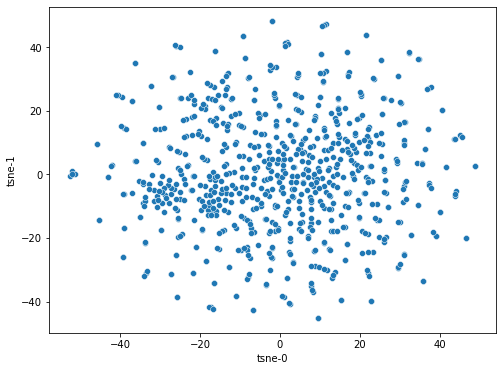

<IPython.core.display.Javascript object>

In [54]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(data=embs, x="tsne-0", y="tsne-1", cmap="viridis")

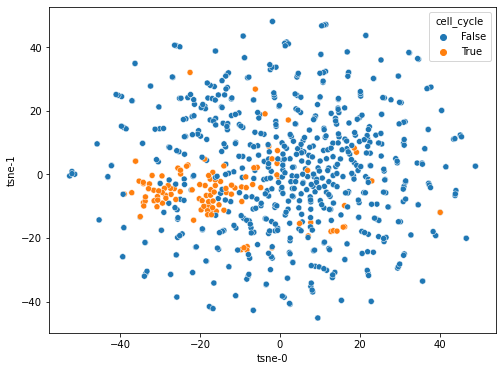

<IPython.core.display.Javascript object>

In [55]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cell_cycle"
)

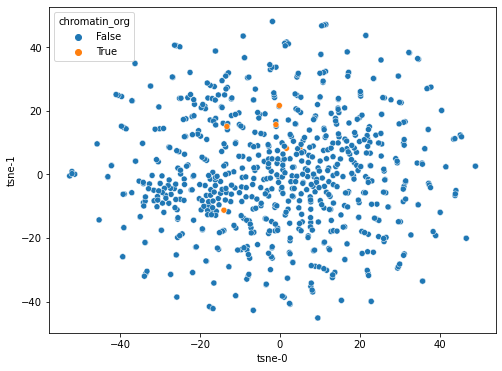

<IPython.core.display.Javascript object>

In [56]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="chromatin_org"
)

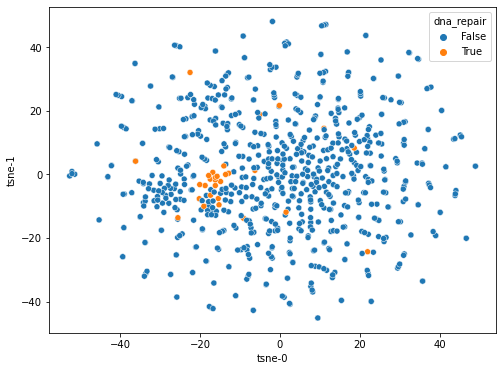

<IPython.core.display.Javascript object>

In [57]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="dna_repair"
)

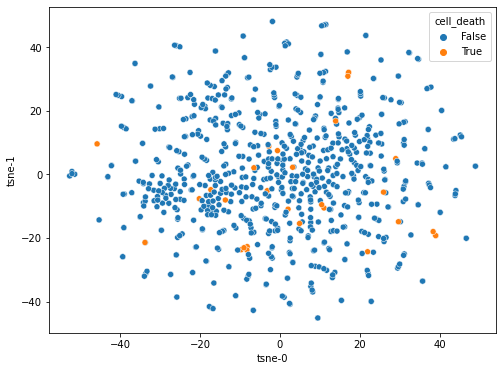

<IPython.core.display.Javascript object>

In [58]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cell_death"
)

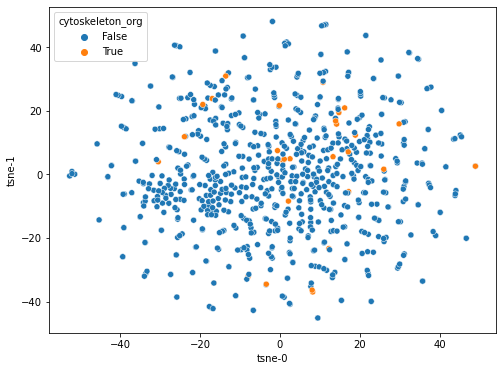

<IPython.core.display.Javascript object>

In [59]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cytoskeleton_org"
)

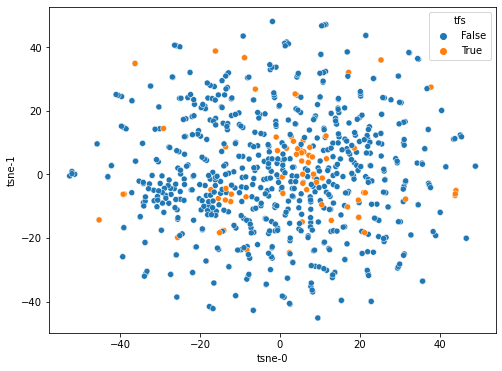

<IPython.core.display.Javascript object>

In [60]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="tfs")

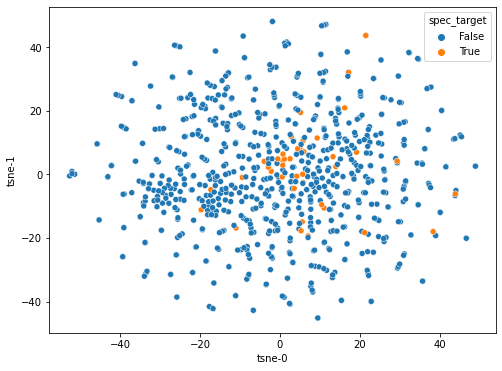

<IPython.core.display.Javascript object>

In [61]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="spec_target"
)

#### Save the embeddings

In [63]:
file_loc = "../../../data/experiments/ppi_embeddings/gae_103121/gae_conf_hub_ext_ppi_w_scgex.csv"
latents = pd.DataFrame(latents, index=node_names)
latents.to_csv(file_loc)

<IPython.core.display.Javascript object>

---


### 3.2. GCAE w. GEX node features

Next, we will train a similar 2-Layer GCAE providing the log-transformed and z-scored gene expression for the 1'126 cells as input.

In [64]:
node_feature_key = "pbulk_gex"
gex_gae = GAE(GCNEncoder(in_channels=3, hidden_dim=128, out_channels=64))
gex_gae

GAE(
  (encoder): GCNEncoder(
    (model): Sequential(
      (0): GCNConv(3, 128)
      (1): PReLU(num_parameters=1)
      (2): GCNConv(128, 64)
    )
  )
  (decoder): InnerProductDecoder()
)

<IPython.core.display.Javascript object>

In [65]:
# inizialize the optimizer
optimizer = torch.optim.Adam(gex_gae.parameters(), lr=0.0001)

<IPython.core.display.Javascript object>

#### Model training

In [66]:
gex_gae, loss_hist = train_gae(
    model=gex_gae,
    data_dict=data_dict,
    node_feature_key=node_feature_key,
    optimizer=optimizer,
    n_epochs=300,
    early_stopping=50,
)

Using cuda
------------------------------------------------------------
EPOCH 1/300
TRAIN loss: 1.3317952156066895
VAL loss: 1.3718600273132324
VAL AUC: 0.6374230165438957 	 AP: 0.6101580577565076
------------------------------------------------------------
EPOCH 2/300
TRAIN loss: 1.3203694820404053
VAL loss: 1.3659358024597168
VAL AUC: 0.6370305518657168 	 AP: 0.6104854890675093
------------------------------------------------------------
EPOCH 3/300
TRAIN loss: 1.335500717163086
VAL loss: 1.3617329597473145
VAL AUC: 0.6371211206376042 	 AP: 0.6114799231271473
------------------------------------------------------------
EPOCH 4/300
TRAIN loss: 1.3405241966247559
VAL loss: 1.3640164136886597
VAL AUC: 0.6366380871875378 	 AP: 0.6123685767599911
------------------------------------------------------------
EPOCH 5/300
TRAIN loss: 1.3225393295288086
VAL loss: 1.352952003479004
VAL AUC: 0.6367890351406834 	 AP: 0.6131180385920776
------------------------------------------------------------


TRAIN loss: 1.3085520267486572
VAL loss: 1.3380155563354492
VAL AUC: 0.6338304552590266 	 AP: 0.62687057347831
------------------------------------------------------------
EPOCH 48/300
TRAIN loss: 1.3013314008712769
VAL loss: 1.349288821220398
VAL AUC: 0.6340115928028016 	 AP: 0.6273488814974322
------------------------------------------------------------
EPOCH 49/300
TRAIN loss: 1.3006863594055176
VAL loss: 1.3537565469741821
VAL AUC: 0.6338908344402849 	 AP: 0.6272270825715037
------------------------------------------------------------
EPOCH 50/300
TRAIN loss: 1.3075649738311768
VAL loss: 1.3546257019042969
VAL AUC: 0.634102161574689 	 AP: 0.6273076380945795
------------------------------------------------------------
EPOCH 51/300
TRAIN loss: 1.2946555614471436
VAL loss: 1.3526604175567627
VAL AUC: 0.6341625407559474 	 AP: 0.6273635847101888
------------------------------------------------------------
EPOCH 52/300
TRAIN loss: 1.3063347339630127
VAL loss: 1.3576598167419434
VAL AUC: 

VAL AUC: 0.640291027653665 	 AP: 0.634157205600744
------------------------------------------------------------
EPOCH 99/300
TRAIN loss: 1.2976033687591553
VAL loss: 1.3565329313278198
VAL AUC: 0.640291027653665 	 AP: 0.633626977037326
------------------------------------------------------------
EPOCH 100/300
TRAIN loss: 1.2919799089431763
VAL loss: 1.349875569343567
VAL AUC: 0.6404117860161817 	 AP: 0.6338063987030496
------------------------------------------------------------
EPOCH 101/300
TRAIN loss: 1.2912933826446533
VAL loss: 1.3581087589263916
VAL AUC: 0.6403212172442942 	 AP: 0.633663988800499
------------------------------------------------------------
EPOCH 102/300
TRAIN loss: 1.2909752130508423
VAL loss: 1.3607432842254639
VAL AUC: 0.6403514068349234 	 AP: 0.6336044992180518
------------------------------------------------------------
EPOCH 103/300
TRAIN loss: 1.2986429929733276
VAL loss: 1.3430428504943848
VAL AUC: 0.6404419756068108 	 AP: 0.633606629799457
---------------

<IPython.core.display.Javascript object>

#### Visualization of the embeddings

In [67]:
graph_data = graph_data.to(gex_gae.device)
inputs = getattr(graph_data, node_feature_key).float()
node_names = getattr(graph_data, "name")
cc_memberships = getattr(graph_data, "cell_cycle")
co_memberships = getattr(graph_data, "chromatin_org")
dr_memberships = getattr(graph_data, "dna_repair")
cd_memberships = getattr(graph_data, "cell_death")
cr_memberships = getattr(graph_data, "cytoskeleton_org")
tf_memberships = getattr(graph_data, "tf")
st_memberships = getattr(graph_data, "spec_target")

<IPython.core.display.Javascript object>

In [68]:
gex_gae.eval()
latents = gex_gae.encode(inputs, graph_data.edge_index)
latents = latents.detach().cpu().numpy()

<IPython.core.display.Javascript object>

In [69]:
norm_zs = StandardScaler().fit_transform(latents)
embs = TSNE(random_state=1234).fit_transform(norm_zs)
embs = pd.DataFrame(embs, columns=["tsne-0", "tsne-1"], index=node_names)
embs["cell_cycle"] = cc_memberships.cpu().numpy()
embs["chromatin_org"] = co_memberships.cpu().numpy()
embs["dna_repair"] = dr_memberships.cpu().numpy()
embs["cell_death"] = cd_memberships.cpu().numpy()
embs["cytoskeleton_org"] = cr_memberships.cpu().numpy()
embs["tfs"] = tf_memberships.cpu().numpy()
embs["spec_target"] = st_memberships.cpu().numpy()

<IPython.core.display.Javascript object>

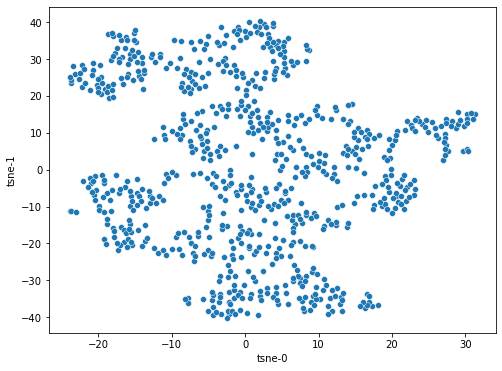

<IPython.core.display.Javascript object>

In [70]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(data=embs, x="tsne-0", y="tsne-1", cmap="viridis")

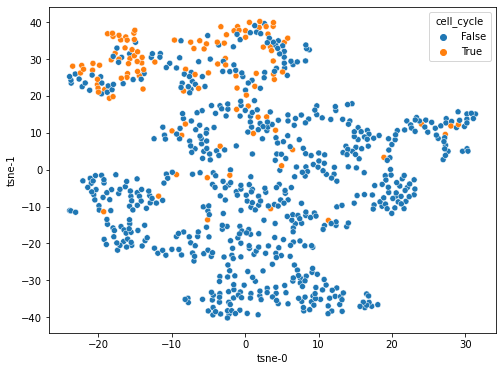

<IPython.core.display.Javascript object>

In [71]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cell_cycle"
)

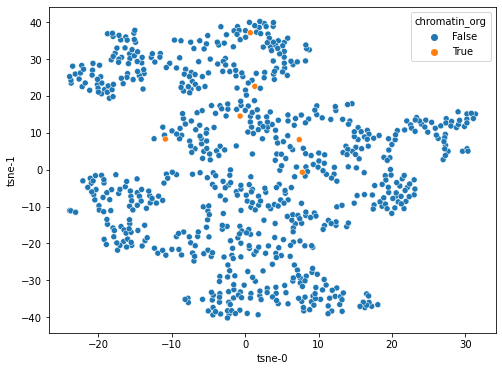

<IPython.core.display.Javascript object>

In [72]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="chromatin_org"
)

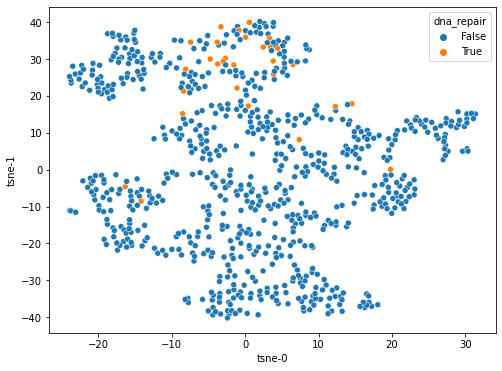

<IPython.core.display.Javascript object>

In [73]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="dna_repair"
)

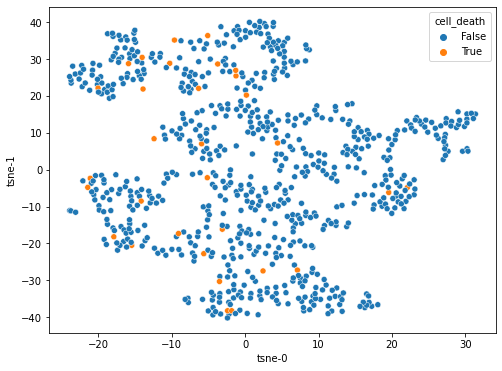

<IPython.core.display.Javascript object>

In [74]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cell_death"
)

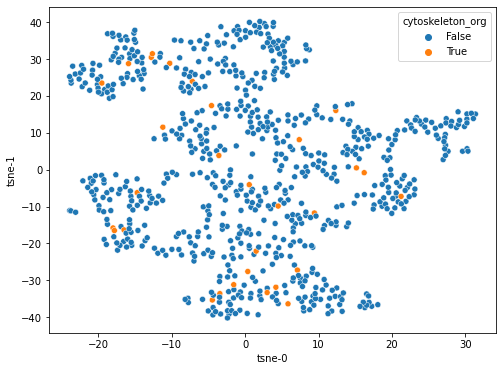

<IPython.core.display.Javascript object>

In [75]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cytoskeleton_org"
)

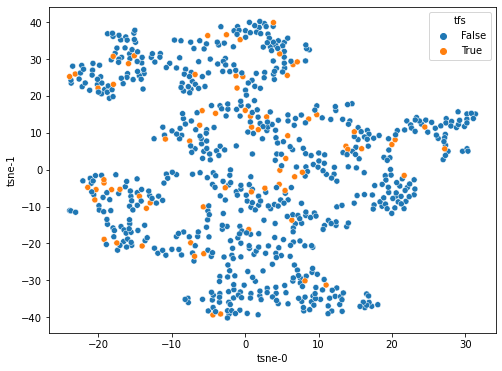

<IPython.core.display.Javascript object>

In [76]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="tfs")

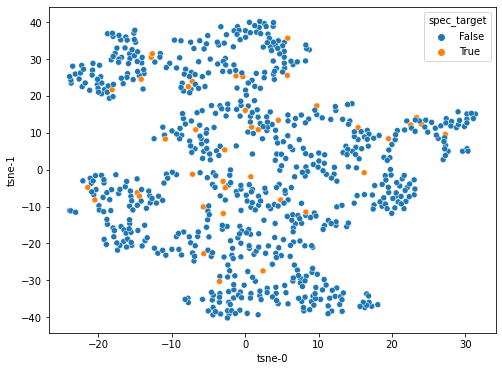

<IPython.core.display.Javascript object>

In [77]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="spec_target"
)

#### Save the embeddings

In [79]:
file_loc = "../../../data/experiments/ppi_embeddings/gae_103121/gae_conf_hub_ext_ppi_w_pbgex.csv"
latents = pd.DataFrame(latents, index=node_names)
latents.to_csv(file_loc)

<IPython.core.display.Javascript object>

---


### 3.2. GCAE w/o node features w. Spearman r edge weight

Next, we will train a similar 2-Layer GCAE providing the log-transformed and z-scored gene expression for the 1'126 cells as input.

In [84]:
node_feature_key = "id"
edge_weight_key = "spearmanr_weight"
spearman_gae = GAE(GCNEncoder(in_channels=754, hidden_dim=128, out_channels=64))
spearman_gae

GAE(
  (encoder): GCNEncoder(
    (model): Sequential(
      (0): GCNConv(754, 128)
      (1): PReLU(num_parameters=1)
      (2): GCNConv(128, 64)
    )
  )
  (decoder): InnerProductDecoder()
)

<IPython.core.display.Javascript object>

In [85]:
# inizialize the optimizer
optimizer = torch.optim.Adam(spearman_gae.parameters(), lr=0.001)

<IPython.core.display.Javascript object>

#### Model training

In [86]:
spearman_gae, loss_hist = train_gae(
    model=spearman_gae,
    data_dict=data_dict,
    node_feature_key=node_feature_key,
    edge_weight_key=edge_weight_key,
    optimizer=optimizer,
    n_epochs=300,
    early_stopping=50,
)

Using cuda
------------------------------------------------------------
EPOCH 1/300
TRAIN loss: 1.3839852809906006
VAL loss: 1.3847737312316895
VAL AUC: 0.7035684096123658 	 AP: 0.6783437415172777
------------------------------------------------------------
EPOCH 2/300
TRAIN loss: 1.382994294166565
VAL loss: 1.383957862854004
VAL AUC: 0.7416978625769834 	 AP: 0.7278344946059995
------------------------------------------------------------
EPOCH 3/300
TRAIN loss: 1.381901741027832
VAL loss: 1.3831638097763062
VAL AUC: 0.7615928028015939 	 AP: 0.7560448090193418
------------------------------------------------------------
EPOCH 4/300
TRAIN loss: 1.3804209232330322
VAL loss: 1.382098913192749
VAL AUC: 0.7685213138509842 	 AP: 0.7742005910081036
------------------------------------------------------------
EPOCH 5/300
TRAIN loss: 1.3784868717193604
VAL loss: 1.3799006938934326
VAL AUC: 0.774785653906533 	 AP: 0.7886136514684845
------------------------------------------------------------
EPO

TRAIN loss: 1.0791823863983154
VAL loss: 1.3565845489501953
VAL AUC: 0.6963832870426278 	 AP: 0.7346870259195886
------------------------------------------------------------
EPOCH 48/300
TRAIN loss: 1.0638606548309326
VAL loss: 1.3792309761047363
VAL AUC: 0.6962323390894819 	 AP: 0.7340571120029721
------------------------------------------------------------
EPOCH 49/300
TRAIN loss: 1.0638988018035889
VAL loss: 1.351331114768982
VAL AUC: 0.6969568892645817 	 AP: 0.7347755027343814
------------------------------------------------------------
EPOCH 50/300
TRAIN loss: 1.0758976936340332
VAL loss: 1.3463554382324219
VAL AUC: 0.6993116773336554 	 AP: 0.7371656442104887
------------------------------------------------------------
EPOCH 51/300
TRAIN loss: 1.0532997846603394
VAL loss: 1.3118152618408203
VAL AUC: 0.7021494988527955 	 AP: 0.740004802453391
------------------------------------------------------------
EPOCH 52/300
TRAIN loss: 1.0656155347824097
VAL loss: 1.3246798515319824
VAL AUC

TRAIN loss: 0.9530923366546631
VAL loss: 1.2817209959030151
VAL AUC: 0.7412752083081754 	 AP: 0.7930157867398999
------------------------------------------------------------
EPOCH 92/300
TRAIN loss: 0.9571755528450012
VAL loss: 1.25382399559021
VAL AUC: 0.7415167250332086 	 AP: 0.7930021259819342
------------------------------------------------------------
EPOCH 93/300
TRAIN loss: 0.9268554449081421
VAL loss: 1.2428295612335205
VAL AUC: 0.7422412752083083 	 AP: 0.7933661364570195
------------------------------------------------------------
EPOCH 94/300
TRAIN loss: 0.9408889412879944
VAL loss: 1.2370409965515137
VAL AUC: 0.7425129815239705 	 AP: 0.793191806714853
------------------------------------------------------------
EPOCH 95/300
TRAIN loss: 0.9382252097129822
VAL loss: 1.2607238292694092
VAL AUC: 0.7431469629271829 	 AP: 0.7938535469604737
------------------------------------------------------------
EPOCH 96/300
TRAIN loss: 0.9575361013412476
VAL loss: 1.2409085035324097
VAL AUC:

TRAIN loss: 0.8791593313217163
VAL loss: 1.209252953529358
VAL AUC: 0.7754800144910036 	 AP: 0.8235763417722016
------------------------------------------------------------
EPOCH 136/300
TRAIN loss: 0.8741201162338257
VAL loss: 1.1743711233139038
VAL AUC: 0.7759026687598116 	 AP: 0.8240489546909512
------------------------------------------------------------
EPOCH 137/300
TRAIN loss: 0.8821914196014404
VAL loss: 1.1771154403686523
VAL AUC: 0.7755705832628911 	 AP: 0.8237357497694726
------------------------------------------------------------
EPOCH 138/300
TRAIN loss: 0.880710780620575
VAL loss: 1.210322380065918
VAL AUC: 0.7754498249003743 	 AP: 0.823559638731671
------------------------------------------------------------
EPOCH 139/300
TRAIN loss: 0.9014521837234497
VAL loss: 1.2090874910354614
VAL AUC: 0.775208308175341 	 AP: 0.8235231973051956
------------------------------------------------------------
EPOCH 140/300
TRAIN loss: 0.8706511855125427
VAL loss: 1.1878761053085327
VAL A

TRAIN loss: 0.8543623089790344
VAL loss: 1.1735398769378662
VAL AUC: 0.7681439439681198 	 AP: 0.825350064104382
------------------------------------------------------------
EPOCH 180/300
TRAIN loss: 0.8270118236541748
VAL loss: 1.1619964838027954
VAL AUC: 0.7688081149619611 	 AP: 0.8260640408884574
------------------------------------------------------------
EPOCH 181/300
TRAIN loss: 0.844554603099823
VAL loss: 1.1577067375183105
VAL AUC: 0.768989252505736 	 AP: 0.8264605958839502
------------------------------------------------------------
EPOCH 182/300
TRAIN loss: 0.8386116027832031
VAL loss: 1.2081753015518188
VAL AUC: 0.7692005796401401 	 AP: 0.8268971216334607
------------------------------------------------------------
EPOCH 183/300
TRAIN loss: 0.8503349423408508
VAL loss: 1.1778855323791504
VAL AUC: 0.7690194420963652 	 AP: 0.8263771222770613
------------------------------------------------------------
EPOCH 184/300
TRAIN loss: 0.8406290411949158
VAL loss: 1.1885638236999512
VAL

<IPython.core.display.Javascript object>

#### Visualization of the embeddings

In [87]:
graph_data = graph_data.to(spearman_gae.device)
inputs = getattr(graph_data, node_feature_key).float()
node_names = getattr(graph_data, "name")
cc_memberships = getattr(graph_data, "cell_cycle")
co_memberships = getattr(graph_data, "chromatin_org")
dr_memberships = getattr(graph_data, "dna_repair")
cd_memberships = getattr(graph_data, "cell_death")
cr_memberships = getattr(graph_data, "cytoskeleton_org")
tf_memberships = getattr(graph_data, "tf")
st_memberships = getattr(graph_data, "spec_target")

<IPython.core.display.Javascript object>

In [88]:
spearman_gae.eval()
latents = spearman_gae.encode(inputs, graph_data.edge_index)
latents = latents.detach().cpu().numpy()

<IPython.core.display.Javascript object>

In [89]:
norm_zs = StandardScaler().fit_transform(latents)
embs = TSNE(random_state=1234).fit_transform(norm_zs)
embs = pd.DataFrame(embs, columns=["tsne-0", "tsne-1"], index=node_names)
embs["cell_cycle"] = cc_memberships.cpu().numpy()
embs["chromatin_org"] = co_memberships.cpu().numpy()
embs["dna_repair"] = dr_memberships.cpu().numpy()
embs["cell_death"] = cd_memberships.cpu().numpy()
embs["cytoskeleton_org"] = cr_memberships.cpu().numpy()
embs["tfs"] = tf_memberships.cpu().numpy()
embs["spec_target"] = st_memberships.cpu().numpy()

<IPython.core.display.Javascript object>

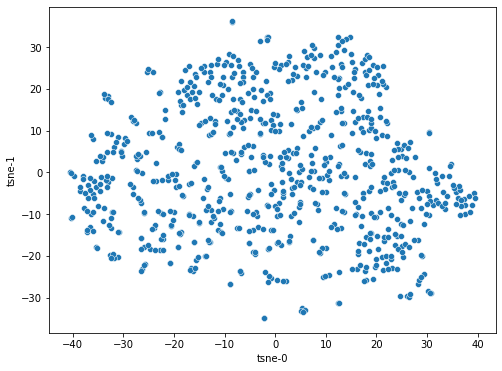

<IPython.core.display.Javascript object>

In [90]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(data=embs, x="tsne-0", y="tsne-1", cmap="viridis")

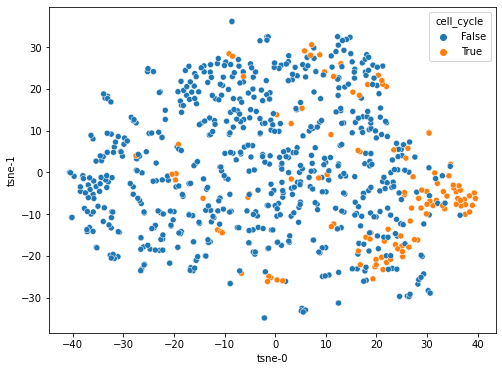

<IPython.core.display.Javascript object>

In [91]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cell_cycle"
)

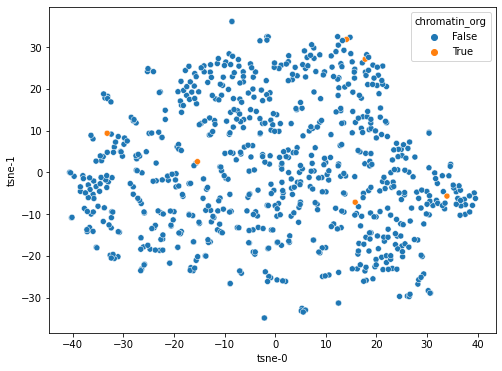

<IPython.core.display.Javascript object>

In [92]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="chromatin_org"
)

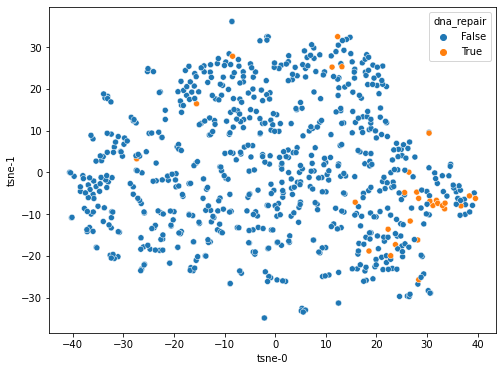

<IPython.core.display.Javascript object>

In [93]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="dna_repair"
)

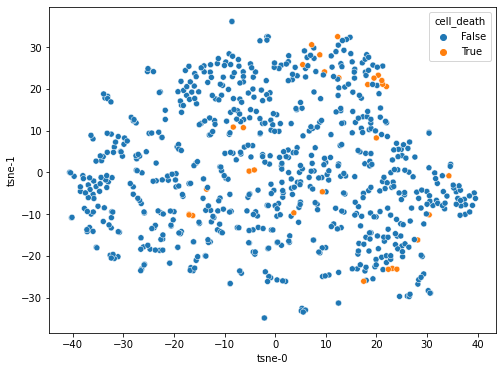

<IPython.core.display.Javascript object>

In [94]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cell_death"
)

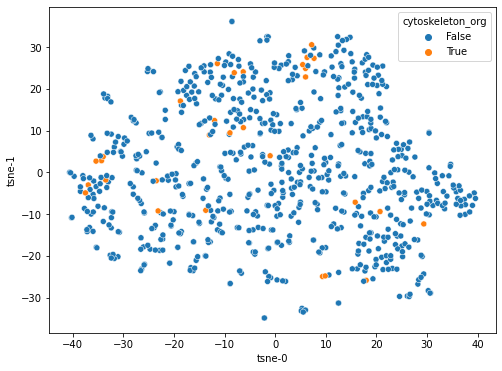

<IPython.core.display.Javascript object>

In [95]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cytoskeleton_org"
)

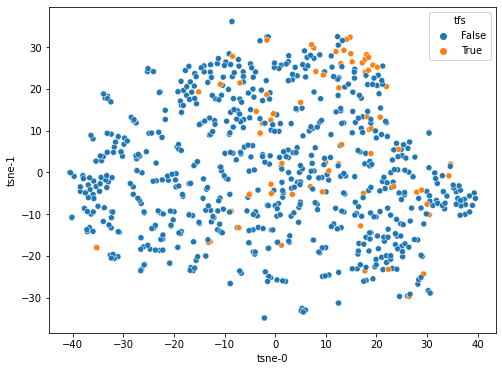

<IPython.core.display.Javascript object>

In [96]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="tfs")

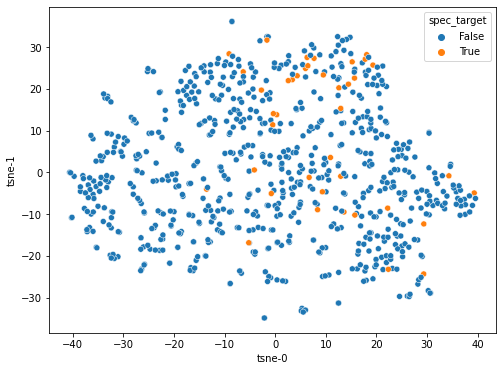

<IPython.core.display.Javascript object>

In [97]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="spec_target"
)

#### Save the embeddings

In [98]:
file_loc = "../../../data/experiments/ppi_embeddings/gae_103121/gae_conf_hub_ext_ppi_wo_gex_w_correlation.csv"
latents = pd.DataFrame(latents, index=node_names)
latents.to_csv(file_loc)

<IPython.core.display.Javascript object>

---


### 3.2. GCAE with GEX node features w. Spearman r edge weight

Next, we will train a similar 2-Layer GCAE providing the log-transformed and z-scored gene expression for the 1'126 cells as input.

In [99]:
node_feature_key = "sc_gex"
edge_weight_key = "spearmanr_weight"
spearman_gex_gae = GAE(GCNEncoder(in_channels=1126, hidden_dim=128, out_channels=64))
spearman_gex_gae

GAE(
  (encoder): GCNEncoder(
    (model): Sequential(
      (0): GCNConv(1126, 128)
      (1): PReLU(num_parameters=1)
      (2): GCNConv(128, 64)
    )
  )
  (decoder): InnerProductDecoder()
)

<IPython.core.display.Javascript object>

In [100]:
# inizialize the optimizer
optimizer = torch.optim.Adam(spearman_gex_gae.parameters(), lr=0.0001)

<IPython.core.display.Javascript object>

#### Model training

In [101]:
spearman_gae, loss_hist = train_gae(
    model=spearman_gex_gae,
    data_dict=data_dict,
    node_feature_key=node_feature_key,
    edge_weight_key=edge_weight_key,
    optimizer=optimizer,
    n_epochs=300,
    early_stopping=50,
)

Using cuda
------------------------------------------------------------
EPOCH 1/300
TRAIN loss: 5.423973560333252
VAL loss: 5.230987071990967
VAL AUC: 0.6865112909068953 	 AP: 0.6838833072805384
------------------------------------------------------------
EPOCH 2/300
TRAIN loss: 4.9011688232421875
VAL loss: 4.739421844482422
VAL AUC: 0.6894698707885522 	 AP: 0.6865136973073726
------------------------------------------------------------
EPOCH 3/300
TRAIN loss: 4.7496256828308105
VAL loss: 4.6288628578186035
VAL AUC: 0.6917340900857384 	 AP: 0.6876357848461788
------------------------------------------------------------
EPOCH 4/300
TRAIN loss: 4.095296382904053
VAL loss: 3.789604902267456
VAL AUC: 0.693922835406352 	 AP: 0.6884880527727755
------------------------------------------------------------
EPOCH 5/300
TRAIN loss: 3.8241488933563232
VAL loss: 3.5958471298217773
VAL AUC: 0.6952360825987199 	 AP: 0.6894231418435383
------------------------------------------------------------
EPOC

TRAIN loss: 1.2828457355499268
VAL loss: 1.7275960445404053
VAL AUC: 0.6797488226059656 	 AP: 0.700170595179305
------------------------------------------------------------
EPOCH 50/300
TRAIN loss: 1.2469000816345215
VAL loss: 1.7155579328536987
VAL AUC: 0.6795978746528197 	 AP: 0.6999704050411236
------------------------------------------------------------
EPOCH 51/300
TRAIN loss: 1.2021721601486206
VAL loss: 1.7270135879516602
VAL AUC: 0.6795073058809322 	 AP: 0.7000702295092449
------------------------------------------------------------
EPOCH 52/300
TRAIN loss: 1.2804323434829712
VAL loss: 1.666745901107788
VAL AUC: 0.6797488226059654 	 AP: 0.7006904793353714
------------------------------------------------------------
EPOCH 53/300
TRAIN loss: 1.1991063356399536
VAL loss: 1.7246220111846924
VAL AUC: 0.6799299601497404 	 AP: 0.6997653989525717
------------------------------------------------------------
EPOCH 54/300
TRAIN loss: 1.234722375869751
VAL loss: 1.7224111557006836
VAL AUC:

TRAIN loss: 1.0813469886779785
VAL loss: 1.5563716888427734
VAL AUC: 0.6998249003743509 	 AP: 0.7261371916774818
------------------------------------------------------------
EPOCH 99/300
TRAIN loss: 1.1039729118347168
VAL loss: 1.5529156923294067
VAL AUC: 0.7003985025963049 	 AP: 0.7266766223754628
------------------------------------------------------------
EPOCH 100/300
TRAIN loss: 1.0750985145568848
VAL loss: 1.5687801837921143
VAL AUC: 0.7015155174495834 	 AP: 0.7275990421945566
------------------------------------------------------------
EPOCH 101/300
TRAIN loss: 1.1076374053955078
VAL loss: 1.5733823776245117
VAL AUC: 0.702421205168458 	 AP: 0.7285615864247286
------------------------------------------------------------
EPOCH 102/300
TRAIN loss: 1.0697274208068848
VAL loss: 1.5613269805908203
VAL AUC: 0.7033268928873324 	 AP: 0.7293954548592199
------------------------------------------------------------
EPOCH 103/300
TRAIN loss: 1.1049941778182983
VAL loss: 1.5620572566986084
VA

VAL AUC: 0.7157650042265427 	 AP: 0.7440527075977539
------------------------------------------------------------
EPOCH 148/300
TRAIN loss: 1.0242115259170532
VAL loss: 1.4677462577819824
VAL AUC: 0.7162480376766092 	 AP: 0.7444875685190917
------------------------------------------------------------
EPOCH 149/300
TRAIN loss: 0.9955665469169617
VAL loss: 1.5058033466339111
VAL AUC: 0.7164593648110131 	 AP: 0.7449699919341318
------------------------------------------------------------
EPOCH 150/300
TRAIN loss: 1.0181972980499268
VAL loss: 1.4972906112670898
VAL AUC: 0.7171839149861128 	 AP: 0.7457519490079098
------------------------------------------------------------
EPOCH 151/300
TRAIN loss: 0.9871115684509277
VAL loss: 1.4969592094421387
VAL AUC: 0.7178480859799543 	 AP: 0.7464685841375768
------------------------------------------------------------
EPOCH 152/300
TRAIN loss: 1.0256328582763672
VAL loss: 1.4821782112121582
VAL AUC: 0.7186330153363121 	 AP: 0.7472158417598813
-------

VAL loss: 1.4061262607574463
VAL AUC: 0.7334862939258544 	 AP: 0.7690456435341656
------------------------------------------------------------
EPOCH 202/300
TRAIN loss: 0.9833461046218872
VAL loss: 1.4498622417449951
VAL AUC: 0.7338787586040333 	 AP: 0.7697670418766831
------------------------------------------------------------
EPOCH 203/300
TRAIN loss: 0.9565411806106567
VAL loss: 1.411675214767456
VAL AUC: 0.7338787586040332 	 AP: 0.7699113738597132
------------------------------------------------------------
EPOCH 204/300
TRAIN loss: 0.9275858402252197
VAL loss: 1.4215857982635498
VAL AUC: 0.734029706557179 	 AP: 0.7701647589970414
------------------------------------------------------------
EPOCH 205/300
TRAIN loss: 0.9569854736328125
VAL loss: 1.4036881923675537
VAL AUC: 0.7342108441009539 	 AP: 0.7704914641155667
------------------------------------------------------------
EPOCH 206/300
TRAIN loss: 0.9409282207489014
VAL loss: 1.3599169254302979
VAL AUC: 0.7343316024634705 	 AP:

VAL AUC: 0.739010989010989 	 AP: 0.7772159796580778
------------------------------------------------------------
EPOCH 247/300
TRAIN loss: 0.94284588098526
VAL loss: 1.3514297008514404
VAL AUC: 0.7389807994203599 	 AP: 0.7772171947821823
------------------------------------------------------------
EPOCH 248/300
TRAIN loss: 0.923608124256134
VAL loss: 1.4134806394577026
VAL AUC: 0.7393128849172805 	 AP: 0.7771276683304691
------------------------------------------------------------
EPOCH 249/300
TRAIN loss: 0.9222767949104309
VAL loss: 1.369537591934204
VAL AUC: 0.7398864871392345 	 AP: 0.7776050331785398
------------------------------------------------------------
EPOCH 250/300
TRAIN loss: 0.9265730977058411
VAL loss: 1.350722074508667
VAL AUC: 0.7397355391860887 	 AP: 0.7776311573208083
------------------------------------------------------------
EPOCH 251/300
TRAIN loss: 0.9162027835845947
VAL loss: 1.3640294075012207
VAL AUC: 0.7398864871392343 	 AP: 0.7777440778171995
-------------

VAL AUC: 0.7513283419876826 	 AP: 0.7950691212304701
------------------------------------------------------------
EPOCH 294/300
TRAIN loss: 0.8938506841659546
VAL loss: 1.3581892251968384
VAL AUC: 0.7518415650283783 	 AP: 0.7953862420733826
------------------------------------------------------------
EPOCH 295/300
TRAIN loss: 0.899702787399292
VAL loss: 1.3254388570785522
VAL AUC: 0.7521132713440405 	 AP: 0.7957076698384506
------------------------------------------------------------
EPOCH 296/300
TRAIN loss: 0.88692706823349
VAL loss: 1.3291971683502197
VAL AUC: 0.7521132713440406 	 AP: 0.7958066093644569
------------------------------------------------------------
EPOCH 297/300
TRAIN loss: 0.9138673543930054
VAL loss: 1.341737985610962
VAL AUC: 0.7523849776597029 	 AP: 0.7959967151023648
------------------------------------------------------------
EPOCH 298/300
TRAIN loss: 0.9041615724563599
VAL loss: 1.381300926208496
VAL AUC: 0.7528982007003985 	 AP: 0.7966132713664607
------------

<IPython.core.display.Javascript object>

#### Visualization of the embeddings

In [102]:
graph_data = graph_data.to(spearman_gae.device)
inputs = getattr(graph_data, node_feature_key).float()
node_names = getattr(graph_data, "name")
cc_memberships = getattr(graph_data, "cell_cycle")
co_memberships = getattr(graph_data, "chromatin_org")
dr_memberships = getattr(graph_data, "dna_repair")
cd_memberships = getattr(graph_data, "cell_death")
cr_memberships = getattr(graph_data, "cytoskeleton_org")
tf_memberships = getattr(graph_data, "tf")
st_memberships = getattr(graph_data, "spec_target")

<IPython.core.display.Javascript object>

In [103]:
spearman_gex_gae.eval()
latents = spearman_gex_gae.encode(inputs, graph_data.edge_index)
latents = latents.detach().cpu().numpy()

<IPython.core.display.Javascript object>

In [104]:
norm_zs = StandardScaler().fit_transform(latents)
embs = TSNE(random_state=1234).fit_transform(norm_zs)
embs = pd.DataFrame(embs, columns=["tsne-0", "tsne-1"], index=node_names)
embs["cell_cycle"] = cc_memberships.cpu().numpy()
embs["chromatin_org"] = co_memberships.cpu().numpy()
embs["dna_repair"] = dr_memberships.cpu().numpy()
embs["cell_death"] = cd_memberships.cpu().numpy()
embs["cytoskeleton_org"] = cr_memberships.cpu().numpy()
embs["tfs"] = tf_memberships.cpu().numpy()
embs["spec_target"] = st_memberships.cpu().numpy()

<IPython.core.display.Javascript object>

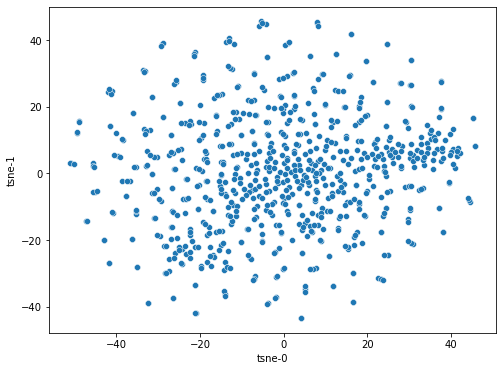

<IPython.core.display.Javascript object>

In [105]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(data=embs, x="tsne-0", y="tsne-1", cmap="viridis")

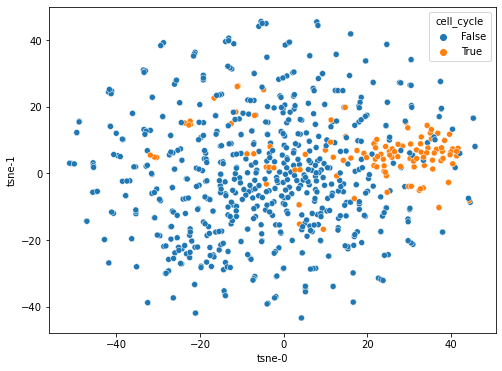

<IPython.core.display.Javascript object>

In [106]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cell_cycle"
)

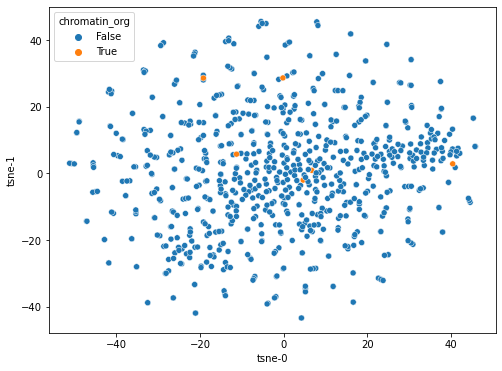

<IPython.core.display.Javascript object>

In [107]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="chromatin_org"
)

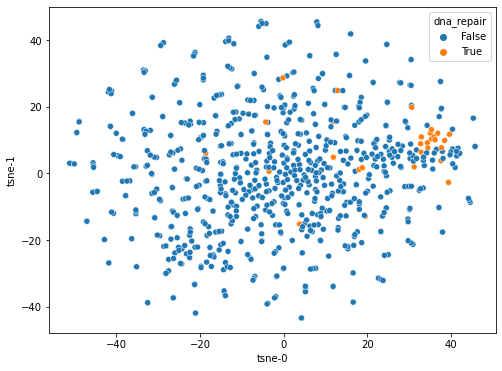

<IPython.core.display.Javascript object>

In [108]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="dna_repair"
)

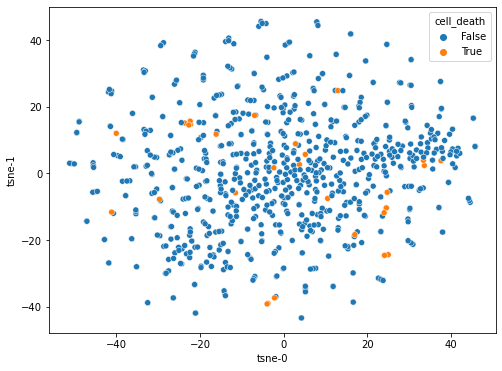

<IPython.core.display.Javascript object>

In [109]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cell_death"
)

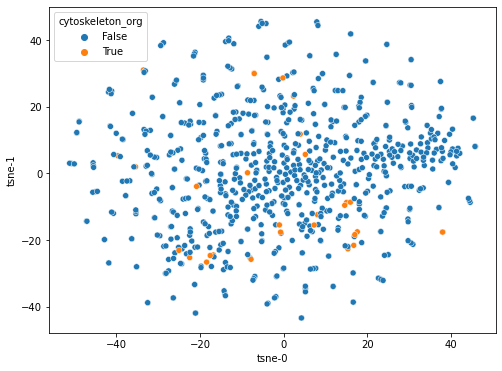

<IPython.core.display.Javascript object>

In [110]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cytoskeleton_org"
)

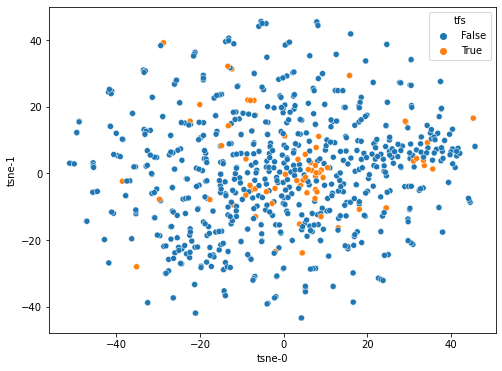

<IPython.core.display.Javascript object>

In [111]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="tfs")

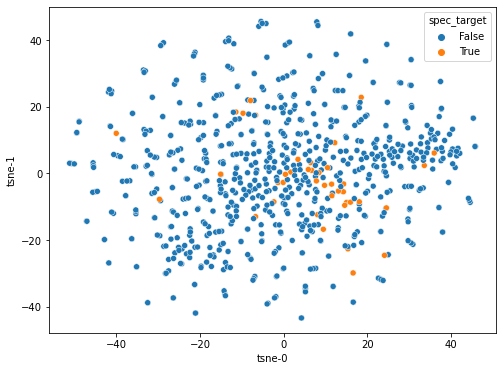

<IPython.core.display.Javascript object>

In [112]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="spec_target"
)

#### Save the embeddings

In [114]:
file_loc = "../../../data/experiments/ppi_embeddings/gae_103121/gae_conf_hub_ext_ppi_w_scgex_w_correlation.csv"
latents = pd.DataFrame(latents, index=node_names)
latents.to_csv(file_loc)

<IPython.core.display.Javascript object>

---

## 4. Node2Vec embeddings

An alternative approach for the node embeddings is Node2Vec that learns an embedding that preserves information of the local neighborhood of it. To this end, we run a number of biased random walks and find node embeddings that captures the likelihood of the co-occurence of two nodes in a respective biased random-walk similar to the word2vec model.

To train the model, we sample positive samples that describe a random-walk of pre-defined size on the graph and negative samples which are not based on the graph structure but purely random.

---

### 4.1. DeepWalk w/o edge weights

We will focus for simplicity on the unbiased case of Node2Vec also known as DeepWalk and first will use that each edge in the derived interactome has weight 1.

#### Model definition

We set the length of the random walks to 30 nodes, the context size to 10 nodes and define to run 50 walks per node. For reasons of comparability we set the embedding dimension to 1.

In [115]:
latent_dim = 64
context_size = 10
walks_per_node = 50
walk_length = 30

<IPython.core.display.Javascript object>

In [116]:
n2v_model = Node2Vec(
    graph_data.edge_index,
    embedding_dim=latent_dim,
    walk_length=walk_length,
    context_size=context_size,
    walks_per_node=walks_per_node,
    num_negative_samples=1,
    p=1,
    q=1,
    sparse=True,
).to(device)
n2v_model.device = device
print(n2v_model)

Node2Vec(754, 64)


<IPython.core.display.Javascript object>

Next, we define the dataloader for a batch size of 128, which corresponds to 128 x 50 x 3 random walks per batch. To speed up the computation we will distribute the computation across 5 different threads. Additionally we define a SparseAdam optimizer to train our model.

In [117]:
batch_size = 128
num_workers = 10

<IPython.core.display.Javascript object>

In [118]:
n2v_loader = n2v_model.loader(
    batch_size=batch_size, shuffle=True, num_workers=num_workers
)
n2v_optimizer = torch.optim.SparseAdam(list(n2v_model.parameters()), lr=0.01)

<IPython.core.display.Javascript object>

#### Model training

We now run the model training once more for 300 epochs, since there is no standardized way to evaluate purely unsupervised token-based embeddings, we will not stop the training early.

In [119]:
def process_single_epoch_n2v(model, optimizer, loader):
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(model.device), neg_rw.to(model.device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


def train_n2v_model(model, optimizer, loader, n_epochs=300):
    for i in range(n_epochs):
        print("EPOCH {}/{}".format(i + 1, n_epochs))
        loss = process_single_epoch_n2v(model=model, optimizer=optimizer, loader=loader)
        print("TRAIN loss:", loss)
        print("---" * 30)
    return model

<IPython.core.display.Javascript object>

In [120]:
fitted_n2v_model = train_n2v_model(
    model=n2v_model, optimizer=n2v_optimizer, loader=n2v_loader
)

EPOCH 1/300
TRAIN loss: 6.332801262537639
------------------------------------------------------------------------------------------
EPOCH 2/300
TRAIN loss: 5.614654620488484
------------------------------------------------------------------------------------------
EPOCH 3/300
TRAIN loss: 4.986852645874023
------------------------------------------------------------------------------------------
EPOCH 4/300
TRAIN loss: 4.465960105260213
------------------------------------------------------------------------------------------
EPOCH 5/300
TRAIN loss: 4.0153781970342
------------------------------------------------------------------------------------------
EPOCH 6/300
TRAIN loss: 3.6317195494969687
------------------------------------------------------------------------------------------
EPOCH 7/300
TRAIN loss: 3.3010350863138833
------------------------------------------------------------------------------------------
EPOCH 8/300
TRAIN loss: 3.0158204237620034
--------------------------

TRAIN loss: 1.0616405407587688
------------------------------------------------------------------------------------------
EPOCH 63/300
TRAIN loss: 1.0610985954602559
------------------------------------------------------------------------------------------
EPOCH 64/300
TRAIN loss: 1.0588815013567607
------------------------------------------------------------------------------------------
EPOCH 65/300
TRAIN loss: 1.0580254395802815
------------------------------------------------------------------------------------------
EPOCH 66/300
TRAIN loss: 1.0556719104448955
------------------------------------------------------------------------------------------
EPOCH 67/300
TRAIN loss: 1.0555455287297566
------------------------------------------------------------------------------------------
EPOCH 68/300
TRAIN loss: 1.0540044903755188
------------------------------------------------------------------------------------------
EPOCH 69/300
TRAIN loss: 1.053260823090871
-------------------------

TRAIN loss: 1.033681571483612
------------------------------------------------------------------------------------------
EPOCH 124/300
TRAIN loss: 1.0337948203086853
------------------------------------------------------------------------------------------
EPOCH 125/300
TRAIN loss: 1.0337874094645183
------------------------------------------------------------------------------------------
EPOCH 126/300
TRAIN loss: 1.034022827943166
------------------------------------------------------------------------------------------
EPOCH 127/300
TRAIN loss: 1.0332794785499573
------------------------------------------------------------------------------------------
EPOCH 128/300
TRAIN loss: 1.0337146321932476
------------------------------------------------------------------------------------------
EPOCH 129/300
TRAIN loss: 1.033948282400767
------------------------------------------------------------------------------------------
EPOCH 130/300
TRAIN loss: 1.0329557061195374
--------------------

TRAIN loss: 1.0304079254468281
------------------------------------------------------------------------------------------
EPOCH 185/300
TRAIN loss: 1.0307965477307637
------------------------------------------------------------------------------------------
EPOCH 186/300
TRAIN loss: 1.0305451552073162
------------------------------------------------------------------------------------------
EPOCH 187/300
TRAIN loss: 1.0303089022636414
------------------------------------------------------------------------------------------
EPOCH 188/300
TRAIN loss: 1.0306244691212971
------------------------------------------------------------------------------------------
EPOCH 189/300
TRAIN loss: 1.0311865210533142
------------------------------------------------------------------------------------------
EPOCH 190/300
TRAIN loss: 1.0304701725641887
------------------------------------------------------------------------------------------
EPOCH 191/300
TRAIN loss: 1.030095060666402
------------------

TRAIN loss: 1.0297279357910156
------------------------------------------------------------------------------------------
EPOCH 246/300
TRAIN loss: 1.0292683243751526
------------------------------------------------------------------------------------------
EPOCH 247/300
TRAIN loss: 1.0301868915557861
------------------------------------------------------------------------------------------
EPOCH 248/300
TRAIN loss: 1.0303621292114258
------------------------------------------------------------------------------------------
EPOCH 249/300
TRAIN loss: 1.029491901397705
------------------------------------------------------------------------------------------
EPOCH 250/300
TRAIN loss: 1.029566466808319
------------------------------------------------------------------------------------------
EPOCH 251/300
TRAIN loss: 1.0294455885887146
------------------------------------------------------------------------------------------
EPOCH 252/300
TRAIN loss: 1.0297253529230754
-------------------

<IPython.core.display.Javascript object>

The loss seems to has converged at 1.105 after training.

#### Visualization of the embeddings

In [121]:
node_names = getattr(graph_data, "name")
cc_memberships = getattr(graph_data, "cell_cycle")
co_memberships = getattr(graph_data, "chromatin_org")
dr_memberships = getattr(graph_data, "dna_repair")
cd_memberships = getattr(graph_data, "cell_death")
cr_memberships = getattr(graph_data, "cytoskeleton_org")
tf_memberships = getattr(graph_data, "tf")
st_memberships = getattr(graph_data, "spec_target")

<IPython.core.display.Javascript object>

In [122]:
fitted_n2v_model.eval()
latents = (
    fitted_n2v_model(torch.arange(graph_data.num_nodes, device=device))
    .cpu()
    .detach()
    .numpy()
)

<IPython.core.display.Javascript object>

In [123]:
norm_zs = StandardScaler().fit_transform(latents)
embs = TSNE(random_state=1234).fit_transform(norm_zs)
embs = pd.DataFrame(embs, columns=["tsne-0", "tsne-1"], index=node_names)
embs["cell_cycle"] = cc_memberships.cpu().numpy()
embs["chromatin_org"] = co_memberships.cpu().numpy()
embs["dna_repair"] = dr_memberships.cpu().numpy()
embs["cell_death"] = cd_memberships.cpu().numpy()
embs["cytoskeleton_org"] = cr_memberships.cpu().numpy()
embs["tfs"] = tf_memberships.cpu().numpy()
embs["spec_target"] = st_memberships.cpu().numpy()

<IPython.core.display.Javascript object>

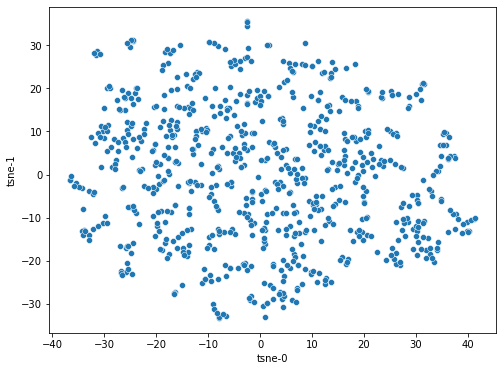

<IPython.core.display.Javascript object>

In [124]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(data=embs, x="tsne-0", y="tsne-1", cmap="viridis")

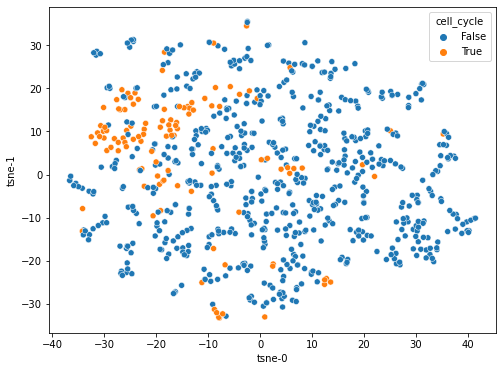

<IPython.core.display.Javascript object>

In [125]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cell_cycle"
)

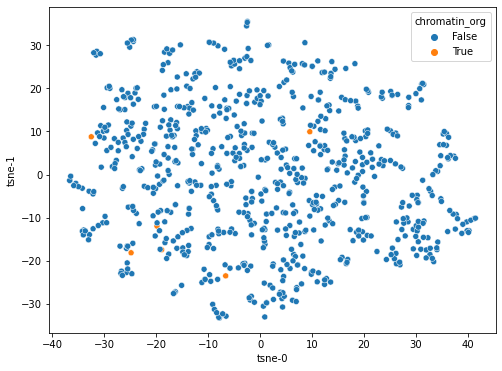

<IPython.core.display.Javascript object>

In [126]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="chromatin_org"
)

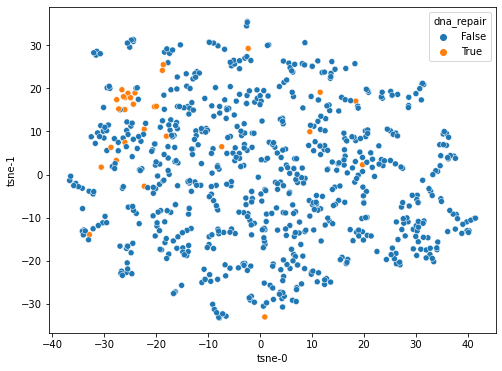

<IPython.core.display.Javascript object>

In [127]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="dna_repair"
)

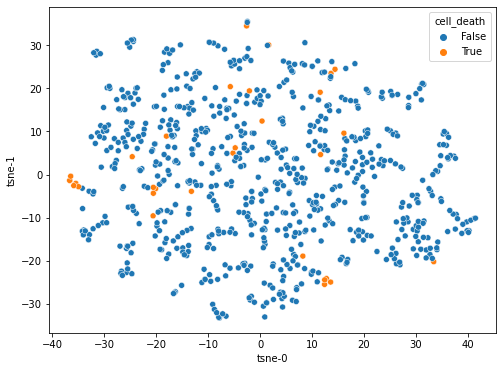

<IPython.core.display.Javascript object>

In [128]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cell_death"
)

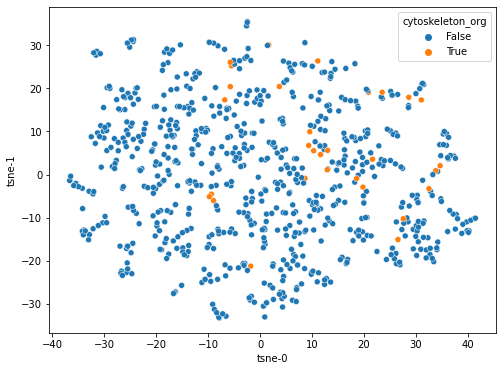

<IPython.core.display.Javascript object>

In [129]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="cytoskeleton_org"
)

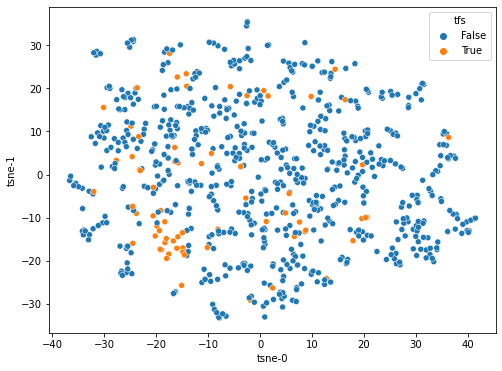

<IPython.core.display.Javascript object>

In [130]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="tfs")

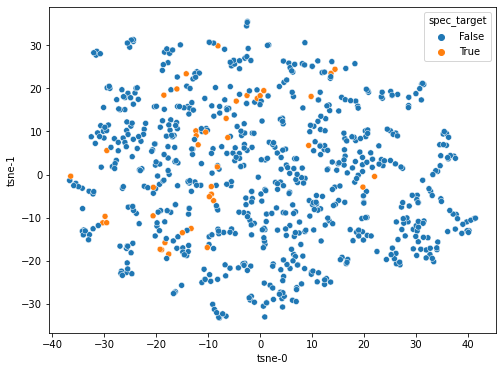

<IPython.core.display.Javascript object>

In [131]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.scatterplot(
    data=embs, x="tsne-0", y="tsne-1", cmap="viridis", hue="spec_target"
)

#### Save the embeddings

In [132]:
file_loc = (
    "../../../data/experiments/ppi_embeddings/gae_103121/n2v_conf_hub_ext_ppi.csv"
)
latents = pd.DataFrame(latents, index=node_names)
latents.to_csv(file_loc)

<IPython.core.display.Javascript object>